# 0. Import Package and Load Data 

In [588]:
import numpy as np 
import pandas as pd 
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopandas as gpd
import matplotlib.font_manager as fm
import folium
import folium.plugins
from IPython.display import IFrame
import json
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import DualMap
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import preprocessing
warnings.filterwarnings("ignore")
fm.get_fontconfig_fonts()
font = fm.FontProperties(fname='../input/font-list/NanumBarunGothic.ttf')
matplotlib.rc('font', family=font.get_name())
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)


In [589]:
time_df_list = []
age_df_list = []
for x in [201902,201903,201904,201905,202002,202003,202004,202005]:
    time_df_list.append('../input/sk-pop-flow/SK_유동인구/4_FLOW_TIME_'+str(x)+'.CSV')
    age_df_list.append('../input/sk-pop-flow/SK_유동인구/4_FLOW_AGE_'+str(x)+'.CSV')
time_df = pd.concat([pd.read_csv(path,sep='|') for path in time_df_list])
age_df = pd.concat([pd.read_csv(path,sep='|') for path in age_df_list])        

In [590]:
print('time_df shape:',time_df.shape)
print('age_df shape:',age_df.shape)

time_df shape: (16629, 28)
age_df shape: (16629, 34)


In [591]:
print('time_df Has 0 value in columns:',time_df.columns[time_df.min()==0].tolist()) 
print('age_df Has 0 value in columns:',age_df.columns[age_df.min()==0].tolist())

time_df Has 0 value in columns: []
age_df Has 0 value in columns: ['MAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0004']


In [592]:
print('00~04 male mean pop flow:',age_df.MAN_FLOW_POP_CNT_0004.mean())
print('00~04 female mean pop flow:',age_df.WMAN_FLOW_POP_CNT_0004.mean())
# SK제공 유동인구데이터 (SK텔레콤 가입자 기준 --> 00~04 영유아 집계 X)

00~04 male mean pop flow: 0.25103012808948455
00~04 female mean pop flow: 0.09531601419207328


In [593]:
time_df.reset_index(drop=True,inplace=True)
age_df.reset_index(drop=True,inplace=True)

In [594]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['figure.figsize'] = (15,15)

geo_meta = gpd.read_file('../input/sk-pop-flow/SK_유동인구/4_.SHP')
geo_meta.head(2)

,STD_YYYY,HDONG_CD,HDONG_NM,SIDO_CD,SIDO_NM,SGNG_CD,SGNG_NM,AREA,LENGTH,X_COORD,Y_COORD,geometry
0,2020,2726067000,고산1동,27,대구광역시,27260,수성구,8881312.38,17757.54,128.69963062806,35.8117467030855,"POLYGON ((1110163.050 1760631.159, 1110159.980..."
1,2020,2726068000,고산2동,27,대구광역시,27260,수성구,24523329.28,25763.81,128.677147073408,35.838758403345,"POLYGON ((1108750.463 1760472.331, 1108750.254..."


In [595]:
print(geo_meta[:35].SIDO_NM.unique()) # index 0 ~34 : 대구    35 ~ 68 : 서울
print(geo_meta[:35].SGNG_NM.unique())

['대구광역시']
['수성구' '중구']


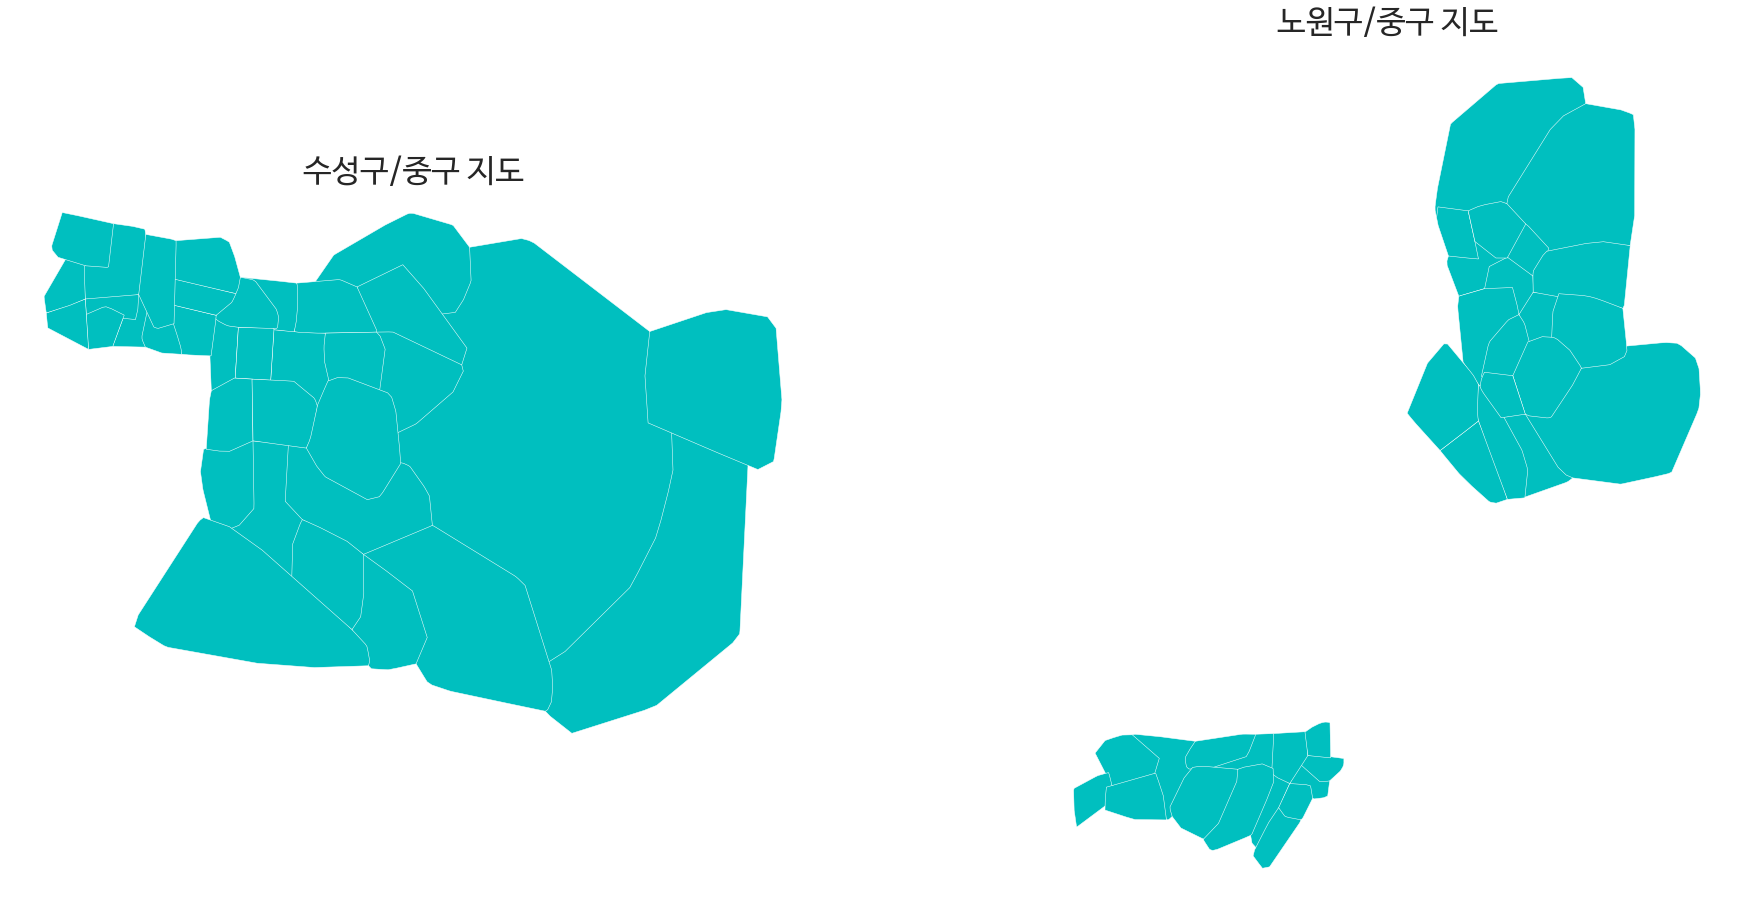

In [596]:
fig,ax = plt.subplots(1,2,figsize=(32,16))
geo_meta[:35].convex_hull.plot(color='c',edgecolor='w',ax=ax[0])
ax[0].set_title('수성구/중구 지도',fontproperties=font,size=32)
ax[0].set_axis_off()
ax[1] = geo_meta[35:].convex_hull.plot(color='c',edgecolor='w',ax=ax[1])
ax[1].set_title('노원구/중구 지도',fontproperties=font,size=32)
ax[1].set_axis_off()

plt.show()

In [597]:
geo_json = '../input/seoulgeo/seoul-dong.geojson'
geo_meta[['X_COORD','Y_COORD']]=geo_meta[['X_COORD','Y_COORD']].apply(pd.to_numeric)

In [598]:
seoul_dong_name=geo_meta[geo_meta.SIDO_NM=='서울특별시'].HDONG_NM.unique()
daegu_dong_name=geo_meta[geo_meta.SIDO_NM=='대구광역시'].HDONG_NM.unique()
print(seoul_dong_name)
print(daegu_dong_name)
print('# 중복된 동 이름:',len(seoul_dong_name.tolist()+daegu_dong_name.tolist())
      -len(set(seoul_dong_name.tolist()+daegu_dong_name.tolist())))

['공릉1동' '공릉2동' '상계10동' '상계1동' '상계2동' '상계3.4동' '상계5동' '상계6.7동' '상계8동'
 '상계9동' '월계1동' '월계2동' '월계3동' '중계1동' '중계2.3동' '중계4동' '중계본동' '하계1동' '하계2동'
 '광희동' '다산동' '동화동' '명동' '소공동' '신당5동' '신당동' '약수동' '을지로동' '장충동' '중림동' '청구동'
 '필동' '황학동' '회현동']
['고산1동' '고산2동' '고산3동' '두산동' '만촌1동' '만촌2동' '만촌3동' '범물1동' '범물2동' '범어1동'
 '범어2동' '범어3동' '범어4동' '상동' '수성1가동' '수성2.3가동' '수성4가동' '중동' '지산1동' '지산2동'
 '파동' '황금1동' '황금2동' '남산1동' '남산2동' '남산3동' '남산4동' '대봉1동' '대봉2동' '대신동' '동인동'
 '삼덕동' '성내1동' '성내2동' '성내3동']
# 중복된 동 이름: 0


In [599]:
time_df['SI_NM'] = time_df.HDONG_NM.isin(seoul_dong_name)
time_df['SI_NM']=time_df['SI_NM'].replace({True:'서울',False:'대구'})
time_df.sample(2)

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,...,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,SI_NM
12655,202004,20200404,1135066500,상계3.4동,2151.43,1822.10,1748.82,1654.72,1633.19,1736.72,...,3247.26,3073.29,3226.58,3041.76,2790.90,2701.64,2559.37,2434.09,2250.76,서울
6138,201904,20190430,2726067000,고산1동,2026.49,1394.99,1160.70,960.69,887.98,1214.09,...,7437.50,8549.57,9350.72,6361.89,11804.70,7717.35,6975.46,5904.08,3826.70,대구


In [600]:
time_df['dayflow']=time_df.loc[:,'TMST_00':'TMST_23'].mean(axis=1)
time_df['date']=pd.to_datetime(time_df['STD_YMD'],format='%Y%m%d')
gu_dict=geo_meta[['HDONG_CD','SGNG_NM']].set_index('HDONG_CD').to_dict()['SGNG_NM']
time_df['GU_NM'] = time_df['HDONG_CD'].apply(lambda x: gu_dict[str(x)] )
time_df['HDONG_CD'] = time_df['HDONG_CD'].apply(pd.to_numeric)
time_df.loc[time_df[(time_df['HDONG_CD']>=2000000000)&(time_df['GU_NM']=='중구')]['GU_NM'].index,'GU_NM'] = '대구_중구'

In [601]:
time_df.sample(7)

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,...,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,SI_NM,dayflow,date,GU_NM
5177,201904,20190417,1114055000,명동,2330.33,1384.06,1024.22,787.02,1216.73,3147.27,...,24769.82,16184.34,9884.70,9116.28,8487.56,4778.17,서울,14768.11,2019-04-17,중구
14829,202005,20200505,2726065200,지산2동,662.93,482.80,311.94,251.49,221.98,262.12,...,2195.14,1993.49,1785.20,1477.26,1058.50,700.96,대구,1171.93,2020-05-05,수성구
3727,201903,20190327,1114054000,회현동,1826.39,1094.36,524.17,661.91,1948.21,5087.86,...,21670.86,12006.14,10761.54,9844.11,7443.32,3660.44,서울,14345.61,2019-03-27,중구
10725,202003,20200307,1135069500,상계6.7동,2849.64,2208.87,1881.49,1605.86,1582.66,2112.63,...,8587.40,6986.88,5872.55,5680.53,4581.78,3429.29,서울,5827.00,2020-03-07,노원구
7824,201905,20190525,1135064000,상계2동,2515.34,1503.20,1112.48,932.69,837.85,1180.26,...,6996.49,6665.74,5342.78,5089.45,4761.39,3420.42,서울,4353.42,2019-05-25,노원구
16347,202005,20200527,2726065200,지산2동,596.27,389.43,335.41,267.35,209.99,306.05,...,2615.13,2517.48,1889.17,1593.47,1274.23,925.75,대구,1323.93,2020-05-27,수성구
6749,201905,20190509,2726060100,황금1동,1089.43,706.28,476.93,356.26,320.39,482.47,...,4074.73,3946.54,3202.62,2708.31,2013.34,1416.44,대구,2180.48,2019-05-09,수성구


In [602]:
pop=pd.read_csv('../input/dong-pop-data/___5__2011__20200919121627.csv',encoding = 'CP949')
pop=pop.rename(columns={'행정구역(동읍면)별':'행정구역'})

In [603]:
dong_pop=pop[pop.항목=='총인구수 (명)'][['행정구역','2019. 05','2020. 05']].set_index('행정구역').drop(['서울특별시','대구광역시','수성구','중구','노원구'],axis=0)
dong_pop.index=dong_pop.index.str.replace('신당제5동','신당5동')

In [604]:
dong_pop.sort_index(inplace=True)

In [605]:
dong_pop['2019. 05']=dong_pop['2019. 05'].astype(int)
dong_pop['2020. 05']=dong_pop['2020. 05'].astype(int)

In [606]:
dong_pop_avg=pd.DataFrame(dong_pop.sum(axis=1),columns=['인구'])

In [607]:
dong_pop_avg['인구']=(dong_pop_avg['인구']/2).astype(int)

In [608]:
dong_meta=pd.merge(time_df.set_index('HDONG_NM').loc[~time_df.set_index('HDONG_NM').index.duplicated(keep='first')][['SI_NM','GU_NM']].reset_index().rename(columns={'HDONG_NM':'행정구역'}),dong_pop_avg.reset_index())
dong_meta=dong_meta.join(time_df[['HDONG_NM','HDONG_CD']],how='inner').drop('행정구역',1)
dong_meta=dong_meta[['SI_NM','GU_NM','HDONG_NM','HDONG_CD','인구']]
dong_meta.head()

,SI_NM,GU_NM,HDONG_NM,HDONG_CD,인구
0,서울,중구,소공동,1114052000,2086
1,서울,중구,회현동,1114054000,5270
2,서울,중구,명동,1114055000,2898
3,서울,중구,필동,1114057000,4012
4,서울,중구,장충동,1114058000,4706


# 1. 동별 특성 파악 

In [609]:
dong_dayflow_2019=pd.DataFrame(time_df.set_index('date')['2019'].groupby('HDONG_NM').sum()['dayflow'].sort_values(ascending=False))
dong_dayflow_2020=pd.DataFrame(time_df.set_index('date')['2020'].groupby('HDONG_NM').sum()['dayflow'].sort_values(ascending=False))

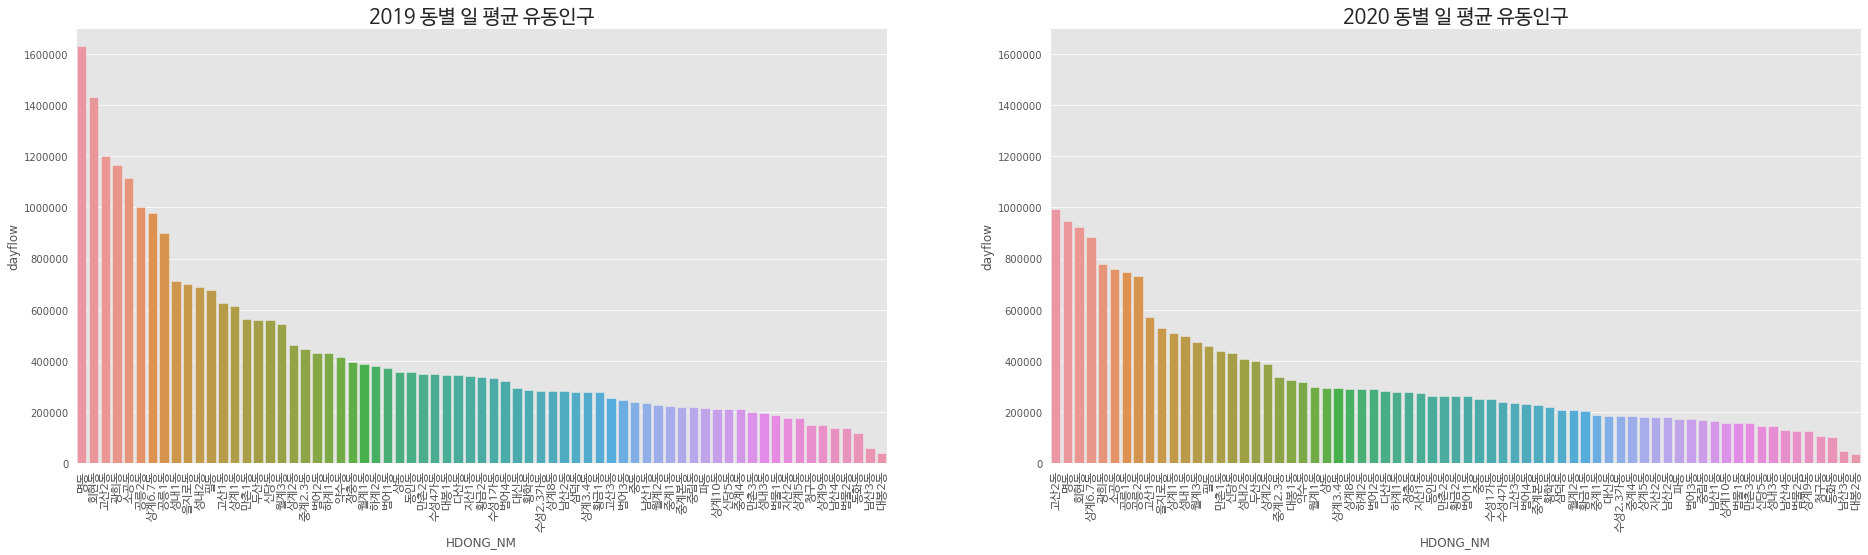

In [610]:
fig,ax=plt.subplots(1,2,figsize=(32,8))
sns.barplot(data=dong_dayflow_2019,x=dong_dayflow_2019.index,y='dayflow',ax=ax[0])
ax[0].set_xticklabels(dong_dayflow_2019.index,fontproperties=font,rotation=90,size=12)
sns.barplot(data=dong_dayflow_2020,x=dong_dayflow_2020.index,y='dayflow',ax=ax[1])
ax[1].set_xticklabels(dong_dayflow_2020.index,fontproperties=font,rotation=90,size=12)
ax[0].set_title('2019 동별 일 평균 유동인구',fontproperties=font,size=20)
ax[1].set_title('2020 동별 일 평균 유동인구',fontproperties=font,size=20)
ax[0].ticklabel_format(style='plain', axis='y')
ax[1].ticklabel_format(style='plain',axis='y')
ax[0].set_ylim([0,1700000])
ax[1].set_ylim([0,1700000])
plt.show()

In [611]:
dong_merged_dayflow=pd.merge(dong_dayflow_2019.reset_index(),dong_dayflow_2020.reset_index(),on='HDONG_NM',suffixes=['_2019','_2020'])
dong_merged_dayflow=dong_merged_dayflow.set_index('HDONG_NM')

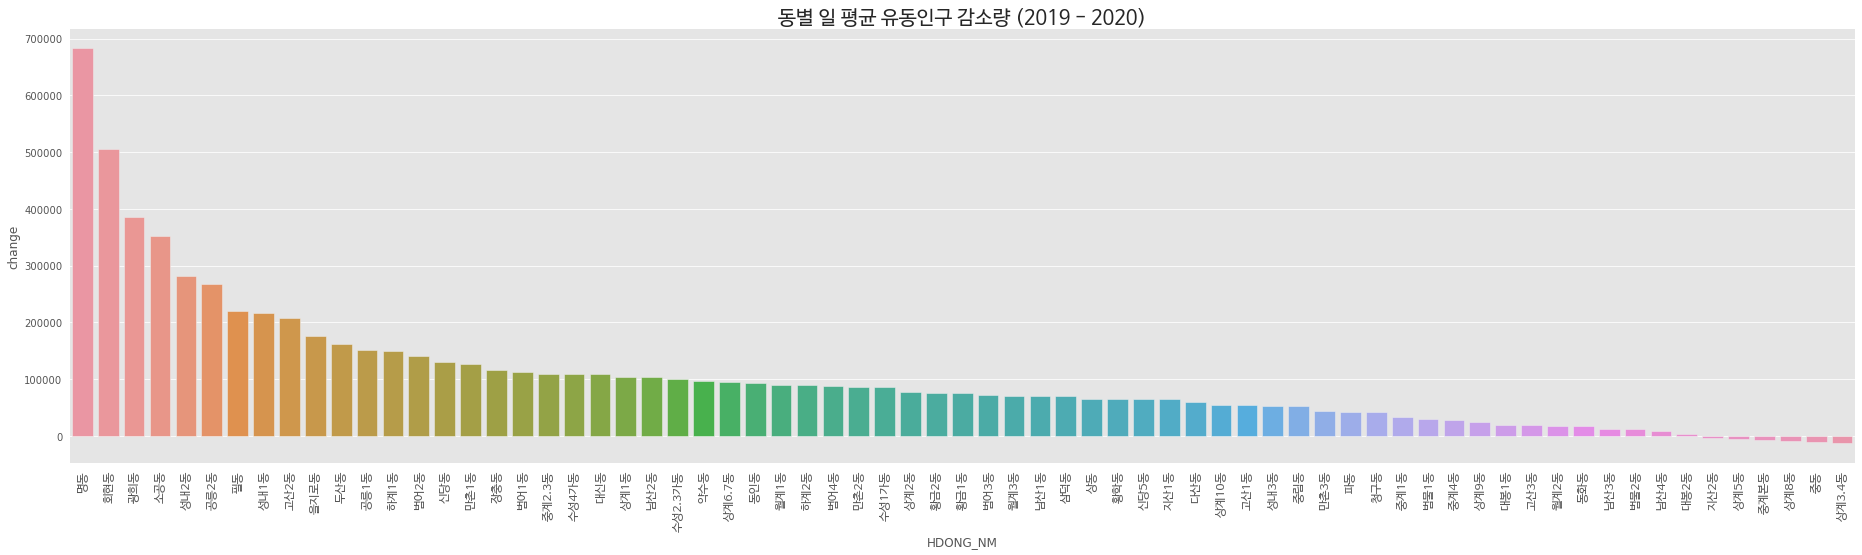

In [612]:
dong_merged_dayflow['change']=dong_merged_dayflow.dayflow_2019-dong_merged_dayflow.dayflow_2020
fig,ax=plt.subplots(figsize=(32,8))
sns.barplot(data=dong_merged_dayflow,x=dong_merged_dayflow.index,y='change',order=dong_merged_dayflow.sort_values('change',ascending=False).index)
ax.ticklabel_format(style='plain',axis='y')
ax.set_xticklabels(dong_merged_dayflow.sort_values('change',ascending=False).index,fontproperties=font,rotation=90,size=12)
ax.set_title('동별 일 평균 유동인구 감소량 (2019 - 2020)',fontproperties=font,size=20)
plt.show()

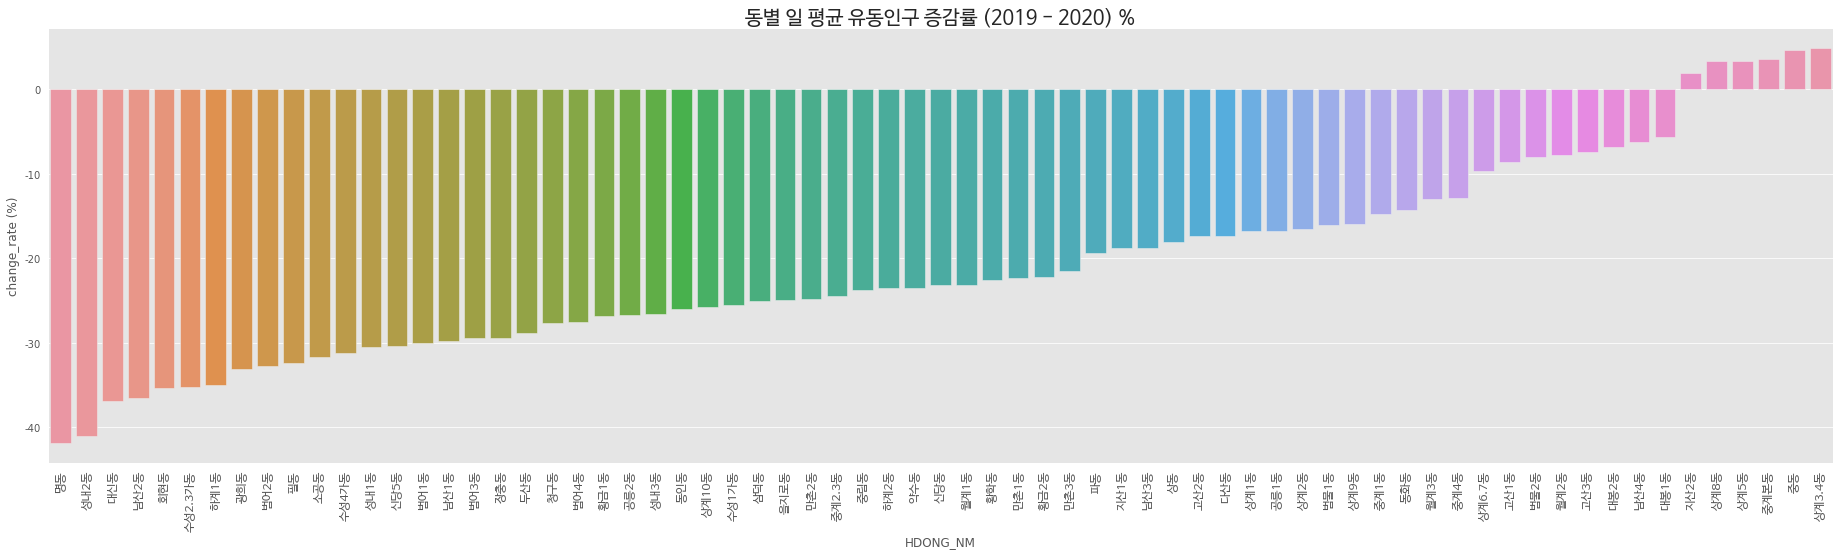

In [613]:
dong_merged_dayflow['change_rate']=(dong_merged_dayflow.dayflow_2020-dong_merged_dayflow.dayflow_2019)/dong_merged_dayflow.dayflow_2019*100
fig,ax=plt.subplots(figsize=(32,8))
sns.barplot(data=dong_merged_dayflow,x=dong_merged_dayflow.index,y='change_rate',order=dong_merged_dayflow.sort_values('change_rate',ascending=True).index)
ax.ticklabel_format(style='plain',axis='y')
ax.set_xticklabels(dong_merged_dayflow.sort_values('change_rate',ascending=True).index,fontproperties=font,rotation=90,size=12)
ax.set_title('동별 일 평균 유동인구 증감률 (2019 - 2020) %',fontproperties=font,size=20)
ax.set_ylabel('change_rate (%)')
plt.show()

In [614]:
dong_meta

,SI_NM,GU_NM,HDONG_NM,HDONG_CD,인구
0,서울,중구,소공동,1114052000,2086
1,서울,중구,회현동,1114054000,5270
2,서울,중구,명동,1114055000,2898
3,서울,중구,필동,1114057000,4012
4,서울,중구,장충동,1114058000,4706
...,...,...,...,...,...
64,대구,수성구,범물1동,2726066100,12071
65,대구,수성구,범물2동,2726066200,16031
66,대구,수성구,고산1동,2726067000,32233
67,대구,수성구,고산2동,2726068000,27923


# 2.  서울(중구 노원구)/대구(중구 수성구) 코로나 전후 월/주/일/시간별 유동인구 추이

In [615]:
seoul_dayflow_2019=time_df[(time_df['date']<'2020') & (time_df['HDONG_NM'].isin(seoul_dong_name))].groupby('HDONG_NM').sum().reset_index()[['HDONG_NM','dayflow']]
seoul_dayflow_2020=time_df[(time_df['date']>='2020') & (time_df['HDONG_NM'].isin(seoul_dong_name))].groupby('HDONG_NM').sum().reset_index()[['HDONG_NM','dayflow']]
daegu_dayflow_2019=time_df[(time_df['date']<'2020') & (time_df
                                                      ['HDONG_NM'].isin(daegu_dong_name))].groupby('HDONG_NM').sum().reset_index()[['HDONG_NM','dayflow']]
daegu_dayflow_2020=time_df[(time_df['date']>='2020') & (time_df['HDONG_NM'].isin(daegu_dong_name))].groupby('HDONG_NM').sum().reset_index()[['HDONG_NM','dayflow']]

In [616]:
seoul_dayflow_2019=pd.merge(pd.merge(dong_pop.reset_index()[['행정구역','2019. 05']],seoul_dayflow_2019,left_on='행정구역',right_on='HDONG_NM').drop('행정구역',axis=1),dong_meta[['HDONG_NM','HDONG_CD']])
seoul_dayflow_2020=pd.merge(pd.merge(dong_pop.reset_index()[['행정구역','2020. 05']],seoul_dayflow_2020,left_on='행정구역',right_on='HDONG_NM').drop('행정구역',axis=1),dong_meta[['HDONG_NM','HDONG_CD']])
daegu_dayflow_2019=pd.merge(pd.merge(dong_pop.reset_index()[['행정구역','2019. 05']],daegu_dayflow_2019,left_on='행정구역',right_on='HDONG_NM').drop('행정구역',axis=1),dong_meta[['HDONG_NM','HDONG_CD']])
daegu_dayflow_2020=pd.merge(pd.merge(dong_pop.reset_index()[['행정구역','2020. 05']],daegu_dayflow_2020,left_on='행정구역',right_on='HDONG_NM').drop('행정구역',axis=1),dong_meta[['HDONG_NM','HDONG_CD']])

In [617]:
seoul_dayflow_2019 = seoul_dayflow_2019.sort_values('HDONG_NM').reset_index(drop=True).rename(columns={'2019. 05':'인구'})
seoul_dayflow_2020 = seoul_dayflow_2020.sort_values('HDONG_NM').reset_index(drop=True).rename(columns={'2020. 05':'인구'})
daegu_dayflow_2019 = daegu_dayflow_2019.sort_values('HDONG_NM').reset_index(drop=True).rename(columns={'2019. 05':'인구'})
daegu_dayflow_2020 = daegu_dayflow_2020.sort_values('HDONG_NM').reset_index(drop=True).rename(columns={'2020. 05':'인구'})

In [618]:
seoul_dayflow_2019['HDONG_CD']=seoul_dayflow_2019.HDONG_CD.astype(str)
seoul_dayflow_2020['HDONG_CD']=seoul_dayflow_2020.HDONG_CD.astype(str)
daegu_dayflow_2019['HDONG_CD']=daegu_dayflow_2019.HDONG_CD.astype(str)
daegu_dayflow_2020['HDONG_CD']=daegu_dayflow_2020.HDONG_CD.astype(str)
seoul_dayflow_2019['dayflow']=seoul_dayflow_2019.dayflow.astype(int)
seoul_dayflow_2020['dayflow']=seoul_dayflow_2020.dayflow.astype(int)
daegu_dayflow_2019['dayflow']=daegu_dayflow_2019.dayflow.astype(int)
daegu_dayflow_2020['dayflow']=daegu_dayflow_2020.dayflow.astype(int)

In [619]:
# with open('../input/korgeo/HangJeongDong_ver20200701.geojson',mode='rt',encoding='utf-8') as f:
#     g = json.loads(f.read())
#     f.close()
# m = folium.plugins.DualMap(location=(37.615,127.046), zoom_start=11.8)
# temp=pd.concat([seoul_dayflow_2019,seoul_dayflow_2020])['dayflow']
# interval=(temp.max()-temp.min())/6
# bins=list(map(float,[temp.min(),temp.min()+interval,temp.min()+interval*2,temp.min()+interval*3,temp.min()+interval*4,temp.min()+interval*5,temp.max()]))
# m.m1.choropleth( geo_data=g, data=seoul_dayflow_2019, columns=('HDONG_CD', 'dayflow'), 
#                   key_on='feature.properties.adm_cd2', fill_color = 'YlOrRd',
#                 fill_opacity=0.8,
#     line_opacity=0.5,
#                 bins=bins)
# m.m2.choropleth( geo_data=g, data=seoul_dayflow_2020, columns=('HDONG_CD', 'dayflow'), 
#                   key_on='feature.properties.adm_cd2', fill_color = 'YlOrRd',fill_opacity=0.8,
#     line_opacity=0.5,
#                 bins=bins)

# m.save('./seoul_year_pop_map.html')
# IFrame(src='./seoul_year_pop_map.html', width=1000, height=600)


"""notebook 느려져서 주석처리 / 한국행정동 파일 (g파일) 읽는데 시간, 메모리 소모 큼 """

'notebook 느려져서 주석처리'

In [620]:
# m = folium.plugins.DualMap(location=(35.843, 128.626), zoom_start=11.8)
# temp=pd.concat([daegu_dayflow_2019,daegu_dayflow_2020])['dayflow']
# interval=(temp.max()-temp.min())/6
# bins=list(map(float,[temp.min(),temp.min()+interval,temp.min()+interval*2,temp.min()+interval*3,temp.min()+interval*4,temp.min()+interval*5,temp.max()]))
# m.m1.choropleth( geo_data=g, data=daegu_dayflow_2019, columns=('HDONG_CD', 'dayflow'), 
#                   key_on='feature.properties.adm_cd2', fill_color = 'YlOrRd',
#                 fill_opacity=0.8,
#     line_opacity=0.5,
#                 bins=bins)
# m.m2.choropleth( geo_data=g, data=daegu_dayflow_2020, columns=('HDONG_CD', 'dayflow'), 
#                   key_on='feature.properties.adm_cd2', fill_color = 'YlOrRd',fill_opacity=0.8,
#     line_opacity=0.5,
#                 bins=bins)

# m.save('./daegu_year_pop_map.html')
# IFrame(src='./daegu_year_pop_map.html', width=1000, height=600)
"""notebook 느려져서 주석처리"""

'notebook 느려져서 주석처리'

In [621]:
seoul_dayflow_2019_geo=pd.merge(seoul_dayflow_2019,geo_meta[['HDONG_NM','X_COORD','Y_COORD']])[['Y_COORD','X_COORD','dayflow']]
seoul_dayflow_2020_geo=pd.merge(seoul_dayflow_2020,geo_meta[['HDONG_NM','X_COORD','Y_COORD']])[['Y_COORD','X_COORD','dayflow']]
daegu_dayflow_2019_geo=pd.merge(daegu_dayflow_2019,geo_meta[['HDONG_NM','X_COORD','Y_COORD']])[['Y_COORD','X_COORD','dayflow']]
daegu_dayflow_2020_geo=pd.merge(daegu_dayflow_2020,geo_meta[['HDONG_NM','X_COORD','Y_COORD']])[['Y_COORD','X_COORD','dayflow']]

In [622]:
# min_flow=min(seoul_dayflow_2019.dayflow.min(),seoul_dayflow_2020.dayflow.min())
# max_flow=max(seoul_dayflow_2019.dayflow.max(),seoul_dayflow_2020.dayflow.max())


In [623]:
# seoul_dayflow_2019_geo['dayflow']=(seoul_dayflow_2019_geo['dayflow'].astype(float)-min_flow)/(max_flow-min_flow)*4000
# seoul_dayflow_2020_geo['dayflow']=(seoul_dayflow_2020_geo['dayflow'].astype(float)-min_flow)/(max_flow-min_flow)*4000

In [624]:
# m = DualMap(location=[37.615, 127.046],
#                     zoom_start = 11.8) 
# colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  0.7: 'yellow', 1: 'red'}
# HeatMap(seoul_dayflow_2019_geo.values.tolist(),radius=30, blur = 1,min_opacity=0).add_to(m.m1)
# HeatMap(seoul_dayflow_2020_geo.values.tolist(),radius=30, blur = 1,min_opcaity=0,gradient=colormap).add_to(m.m2)
# m.save('seoul_year_pop_heatmap.html')
# m
"""HEATMAP - 부적합"""

'HEATMAP - 부적합'

In [625]:
# m = DualMap(location=[35.843, 128.626],
#                     zoom_start = 11.8) 
# HeatMap(daegu_dayflow_2019_geo,radius=30).add_to(m.m1)
# HeatMap(daegu_dayflow_2020_geo,radius=30).add_to(m.m2)
# m
"""HEATMAP - 부적합"""

'HEATMAP - 부적합'

In [626]:
daytime_geo=pd.merge(geo_meta[['HDONG_NM','X_COORD','Y_COORD']],time_df[time_df.date<'2020'].groupby('HDONG_NM').mean().loc[:,'TMST_00':'TMST_23'].reset_index())

In [627]:
### scaling
for col in daytime_geo.loc[:,'TMST_00':'TMST_23'].columns.tolist():
    daytime_geo[col] = daytime_geo[col]/daytime_geo[col].sum()*50

In [628]:
melted_df=pd.melt(daytime_geo.drop('HDONG_NM',axis=1),id_vars=['X_COORD','Y_COORD'])
melted_df=melted_df[['Y_COORD','X_COORD','variable','value']]
melted_df.variable=pd.to_numeric(melted_df.variable.str[5:])

In [629]:
melted_df

,Y_COORD,X_COORD,variable,value
0,35.81,128.70,0,1.11
1,35.84,128.68,0,1.72
2,35.85,128.71,0,0.50
3,35.83,128.62,0,1.50
4,35.87,128.65,0,0.96
...,...,...,...,...
1651,37.56,126.97,23,0.40
1652,37.56,127.02,23,0.32
1653,37.56,126.99,23,0.86
1654,37.57,127.02,23,0.57


In [630]:
hm_arr=[]
for i in range(24):
    hm_arr.append(melted_df.set_index('variable').loc[i,:].values.tolist())

In [631]:
m=folium.Map(location=[37.615, 127.046],
                    zoom_start = 11.8) 
hm = plugins.HeatMapWithTime(hm_arr,auto_play=True,radius=80)
hm.add_to(m)
m

In [632]:
seoul_dayflow=time_df.groupby(['SI_NM','date']).sum().loc['서울','dayflow']
daegu_dayflow=time_df.groupby(['SI_NM','date']).sum().loc['대구','dayflow']
seoul_dayflow=seoul_dayflow.reset_index()
daegu_dayflow=daegu_dayflow.reset_index()
se_dayflow=seoul_dayflow.drop(seoul_dayflow[seoul_dayflow.date=='2020-02-29'].index,axis=0)
da_dayflow=daegu_dayflow.drop(daegu_dayflow[daegu_dayflow.date=='2020-02-29'].index,axis=0)

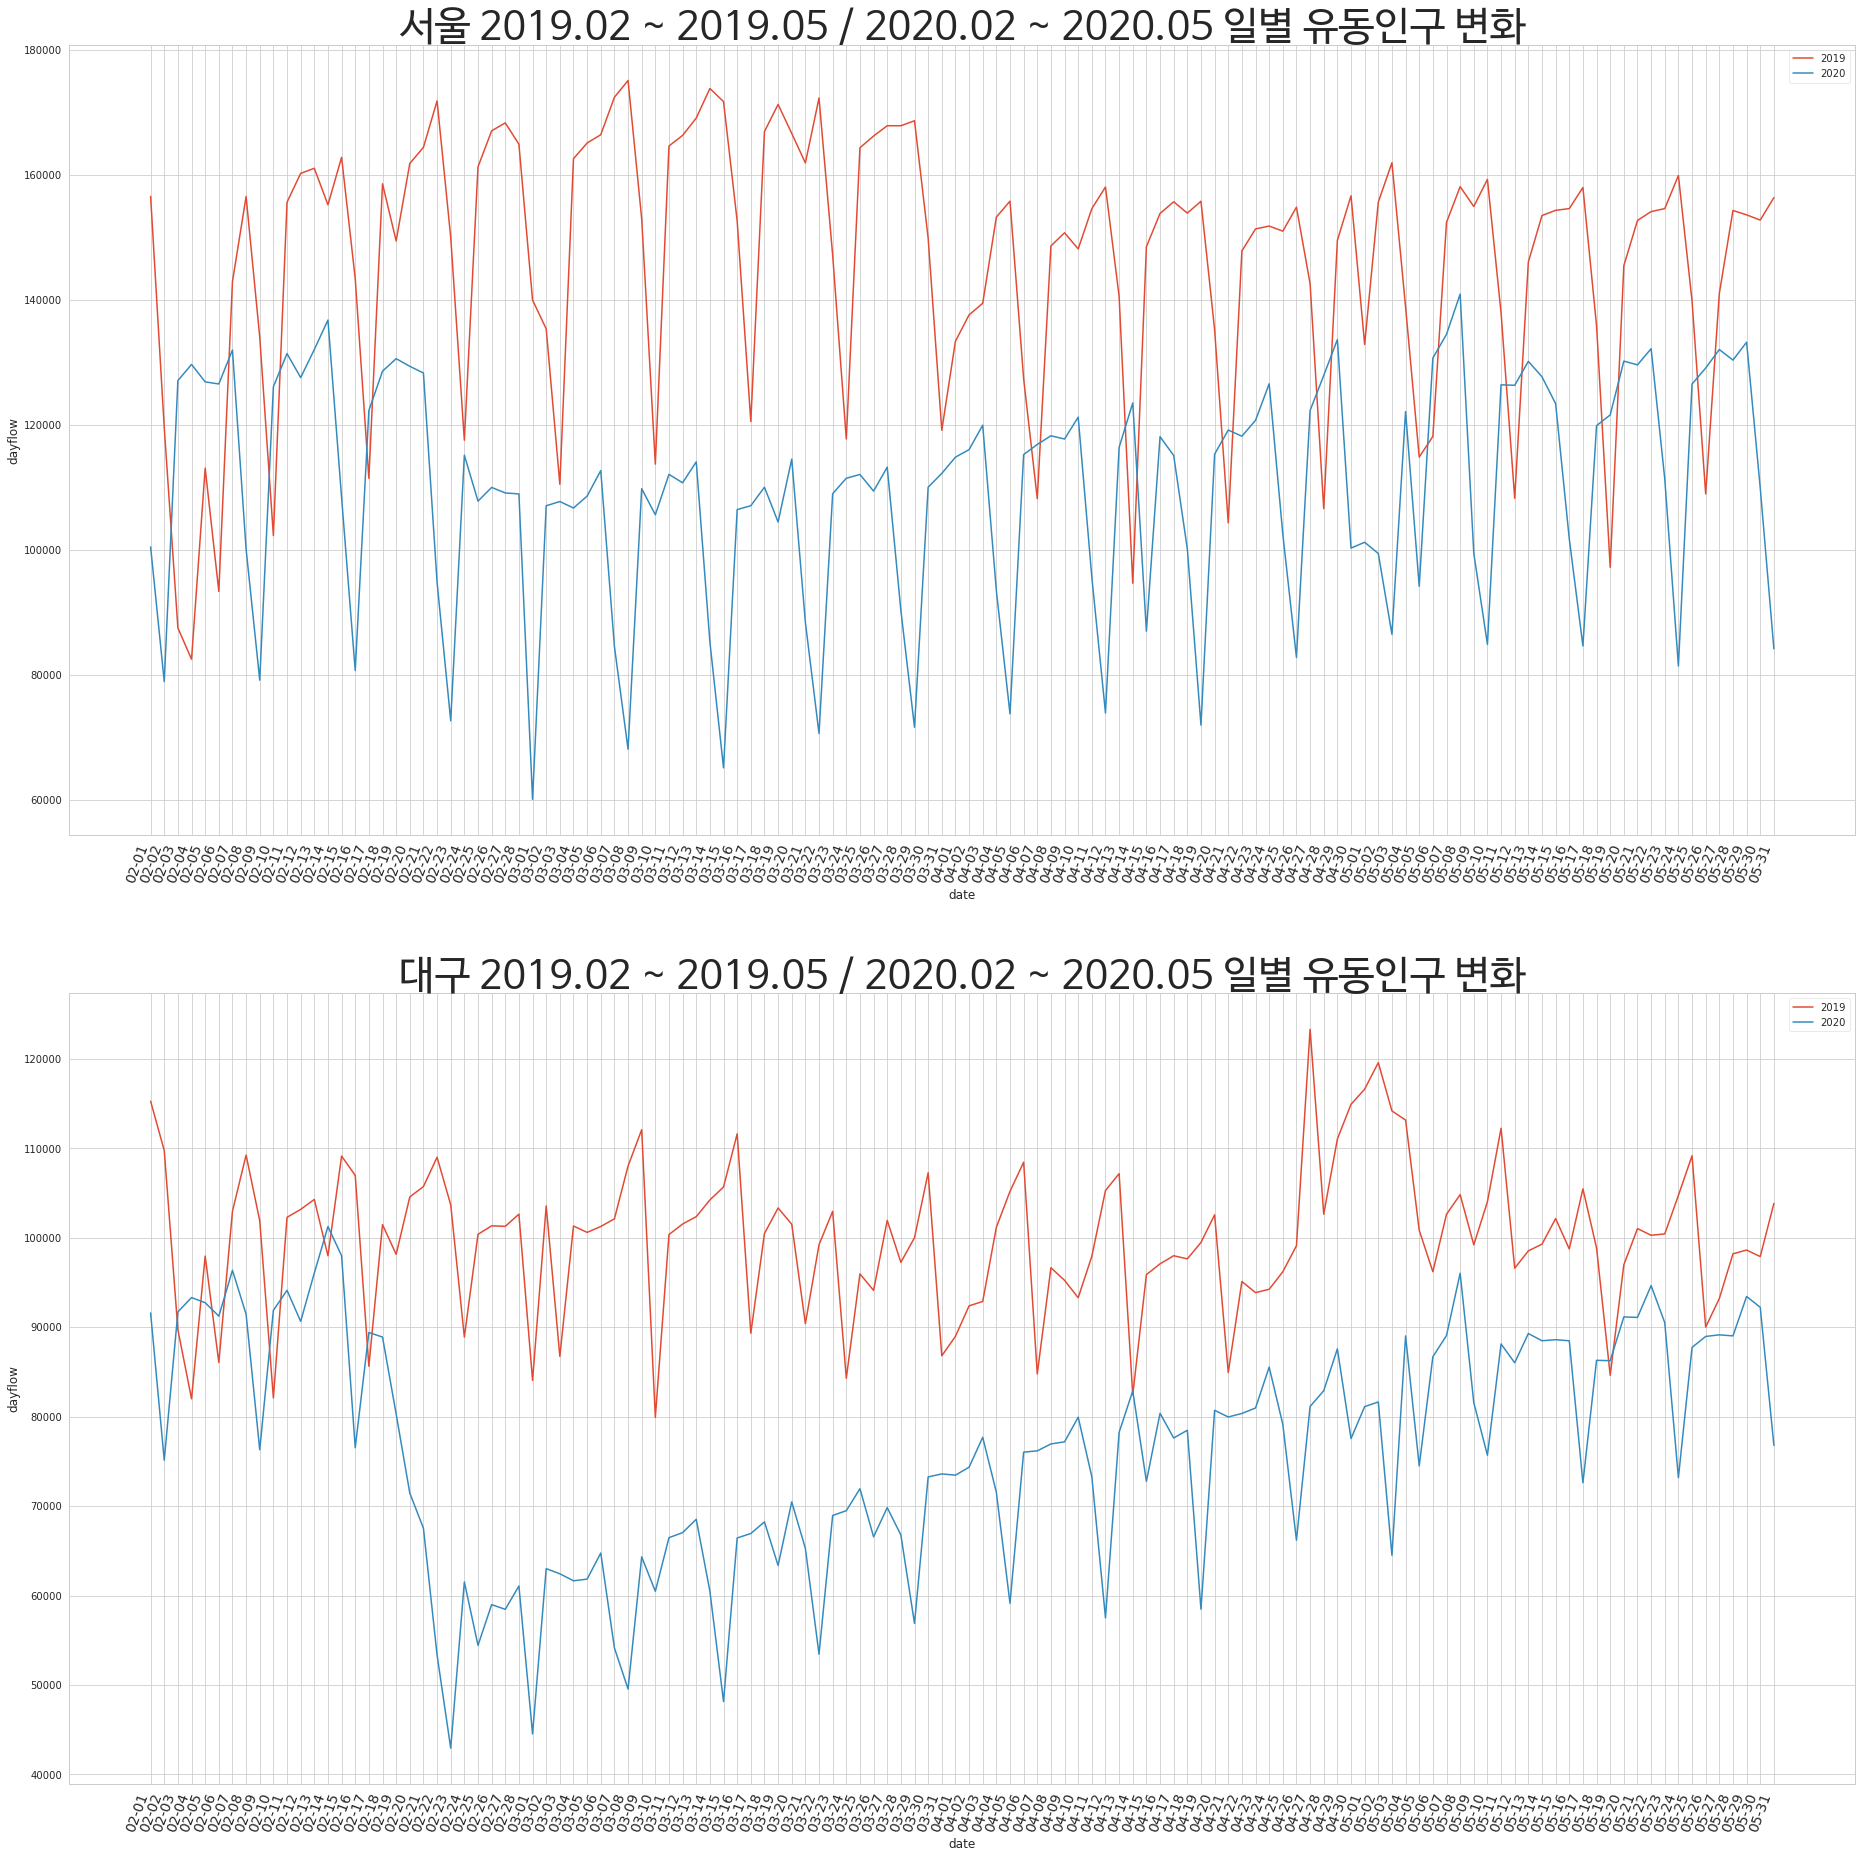

In [633]:
def compare_dayflow(df1,df2,title_1,title_2):
    
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(2,1,figsize=(32,32))
    sns.lineplot(x=df1[df1.date<'2020']['date'].apply(lambda x : x.strftime('%m-%d')),
                 y=df1[df1.date<'2020']['dayflow'],ax=ax[0],label='2019')
    sns.lineplot(x=df1[df1.date>='2020']['date'].apply(lambda x : x.strftime('%m-%d')),
                 y=df1[df1.date>='2020']['dayflow'],ax=ax[0],label='2020')

    sns.lineplot(x=df2[df2.date<'2020']['date'].apply(lambda x : x.strftime('%m-%d')),
                 y=df2[df2.date<'2020']['dayflow'],ax=ax[1],label='2019')
    sns.lineplot(x=df2[df2.date>='2020']['date'].apply(lambda x : x.strftime('%m-%d')),
                 y=df2[df2.date>='2020']['dayflow'],ax=ax[1],label='2020')
    plt.setp(ax[0].get_xticklabels(), rotation=70, ha='right',size=14)
    plt.setp(ax[1].get_xticklabels(), rotation=70, ha='right',size=14)
    ax[0].set_title(title_1,fontproperties=font,size=40)
    ax[1].set_title(title_2,fontproperties=font,size=40)
    plt.legend()
    plt.show()
def compare_weekflow(df1,df2,title_1,title_2):
    
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(2,1,figsize=(32,32))
    sns.lineplot(x=df1[df1.week<'2020']['week'].apply(lambda x : x.strftime('%m-%d')),
                 y=df1[df1.week<'2020']['dayflow'],ax=ax[0],label='2019')
    sns.lineplot(x=df1[df1.week>='2020']['week'].apply(lambda x : x.strftime('%m-%d')),
                 y=df1[df1.week>='2020']['dayflow'],ax=ax[0],label='2020')

    sns.lineplot(x=df2[df2.week<'2020']['week'].apply(lambda x : x.strftime('%m-%d')),
                 y=df2[df2.week<'2020']['dayflow'],ax=ax[1],label='2019')
    sns.lineplot(x=df2[df2.week>='2020']['week'].apply(lambda x : x.strftime('%m-%d')),
                 y=df2[df2.week>='2020']['dayflow'],ax=ax[1],label='2020')
    plt.setp(ax[0].get_xticklabels(), rotation=70, ha='right',size=14)
    plt.setp(ax[1].get_xticklabels(), rotation=70, ha='right',size=14)
    ax[0].set_title(title_1,fontproperties=font,size=40)
    ax[1].set_title(title_2,fontproperties=font,size=40)
    plt.legend()
    plt.show()
compare_dayflow(se_dayflow,da_dayflow,'서울 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화',
               '대구 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화')

In [634]:
suseong_dayflow=time_df.groupby(['GU_NM','date']).sum().loc['수성구','dayflow']
d_jung_dayflow=time_df.groupby(['GU_NM','date']).sum().loc['대구_중구','dayflow']
noone_dayflow=time_df.groupby(['GU_NM','date']).sum().loc['노원구','dayflow']
jung_dayflow=time_df.groupby(['GU_NM','date']).sum().loc['중구','dayflow']

suseong_dayflow=suseong_dayflow.reset_index()
d_jung_dayflow=d_jung_dayflow.reset_index()
noone_dayflow=noone_dayflow.reset_index()
jung_dayflow=jung_dayflow.reset_index()

su_dayflow=suseong_dayflow.drop(suseong_dayflow[suseong_dayflow.date=='2020-02-29'].index,axis=0,)
djung_dayflow=d_jung_dayflow.drop(d_jung_dayflow[d_jung_dayflow.date=='2020-02-29'].index,axis=0,)
no_dayflow=noone_dayflow.drop(noone_dayflow[noone_dayflow.date=='2020-02-29'].index,axis=0,)
sjung_dayflow=jung_dayflow.drop(jung_dayflow[jung_dayflow.date=='2020-02-29'].index,axis=0,)

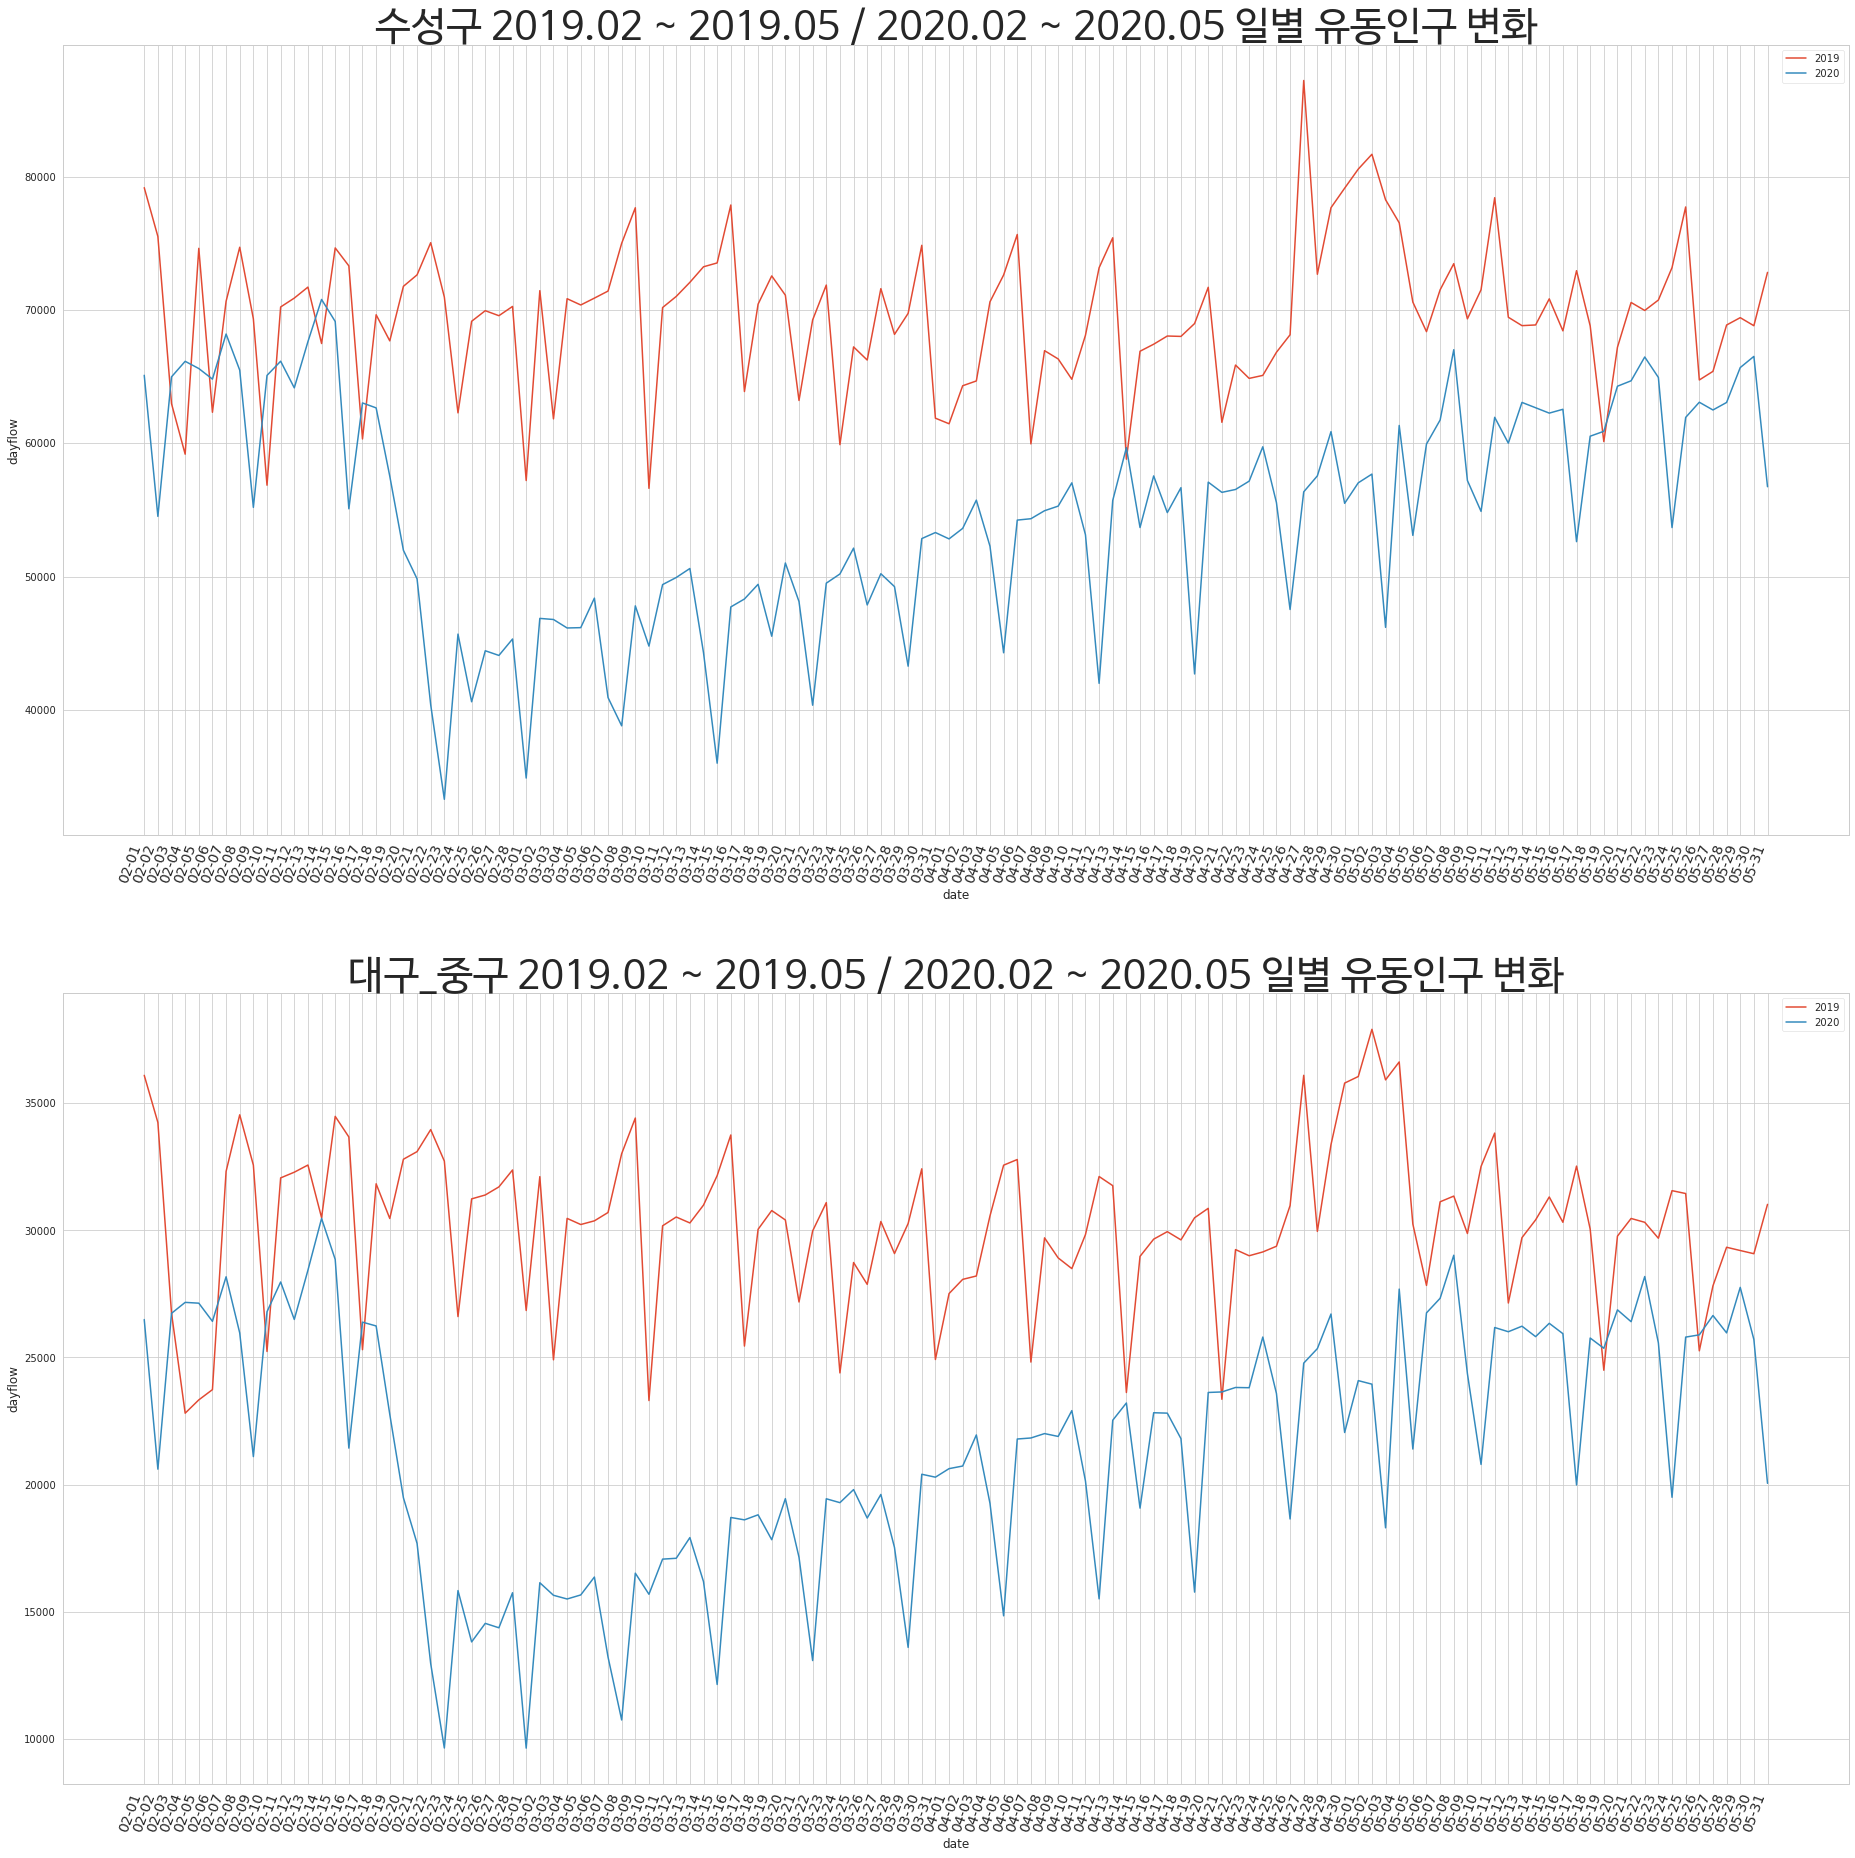

In [635]:
compare_dayflow(su_dayflow,djung_dayflow,'수성구 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화',
               '대구_중구 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화')

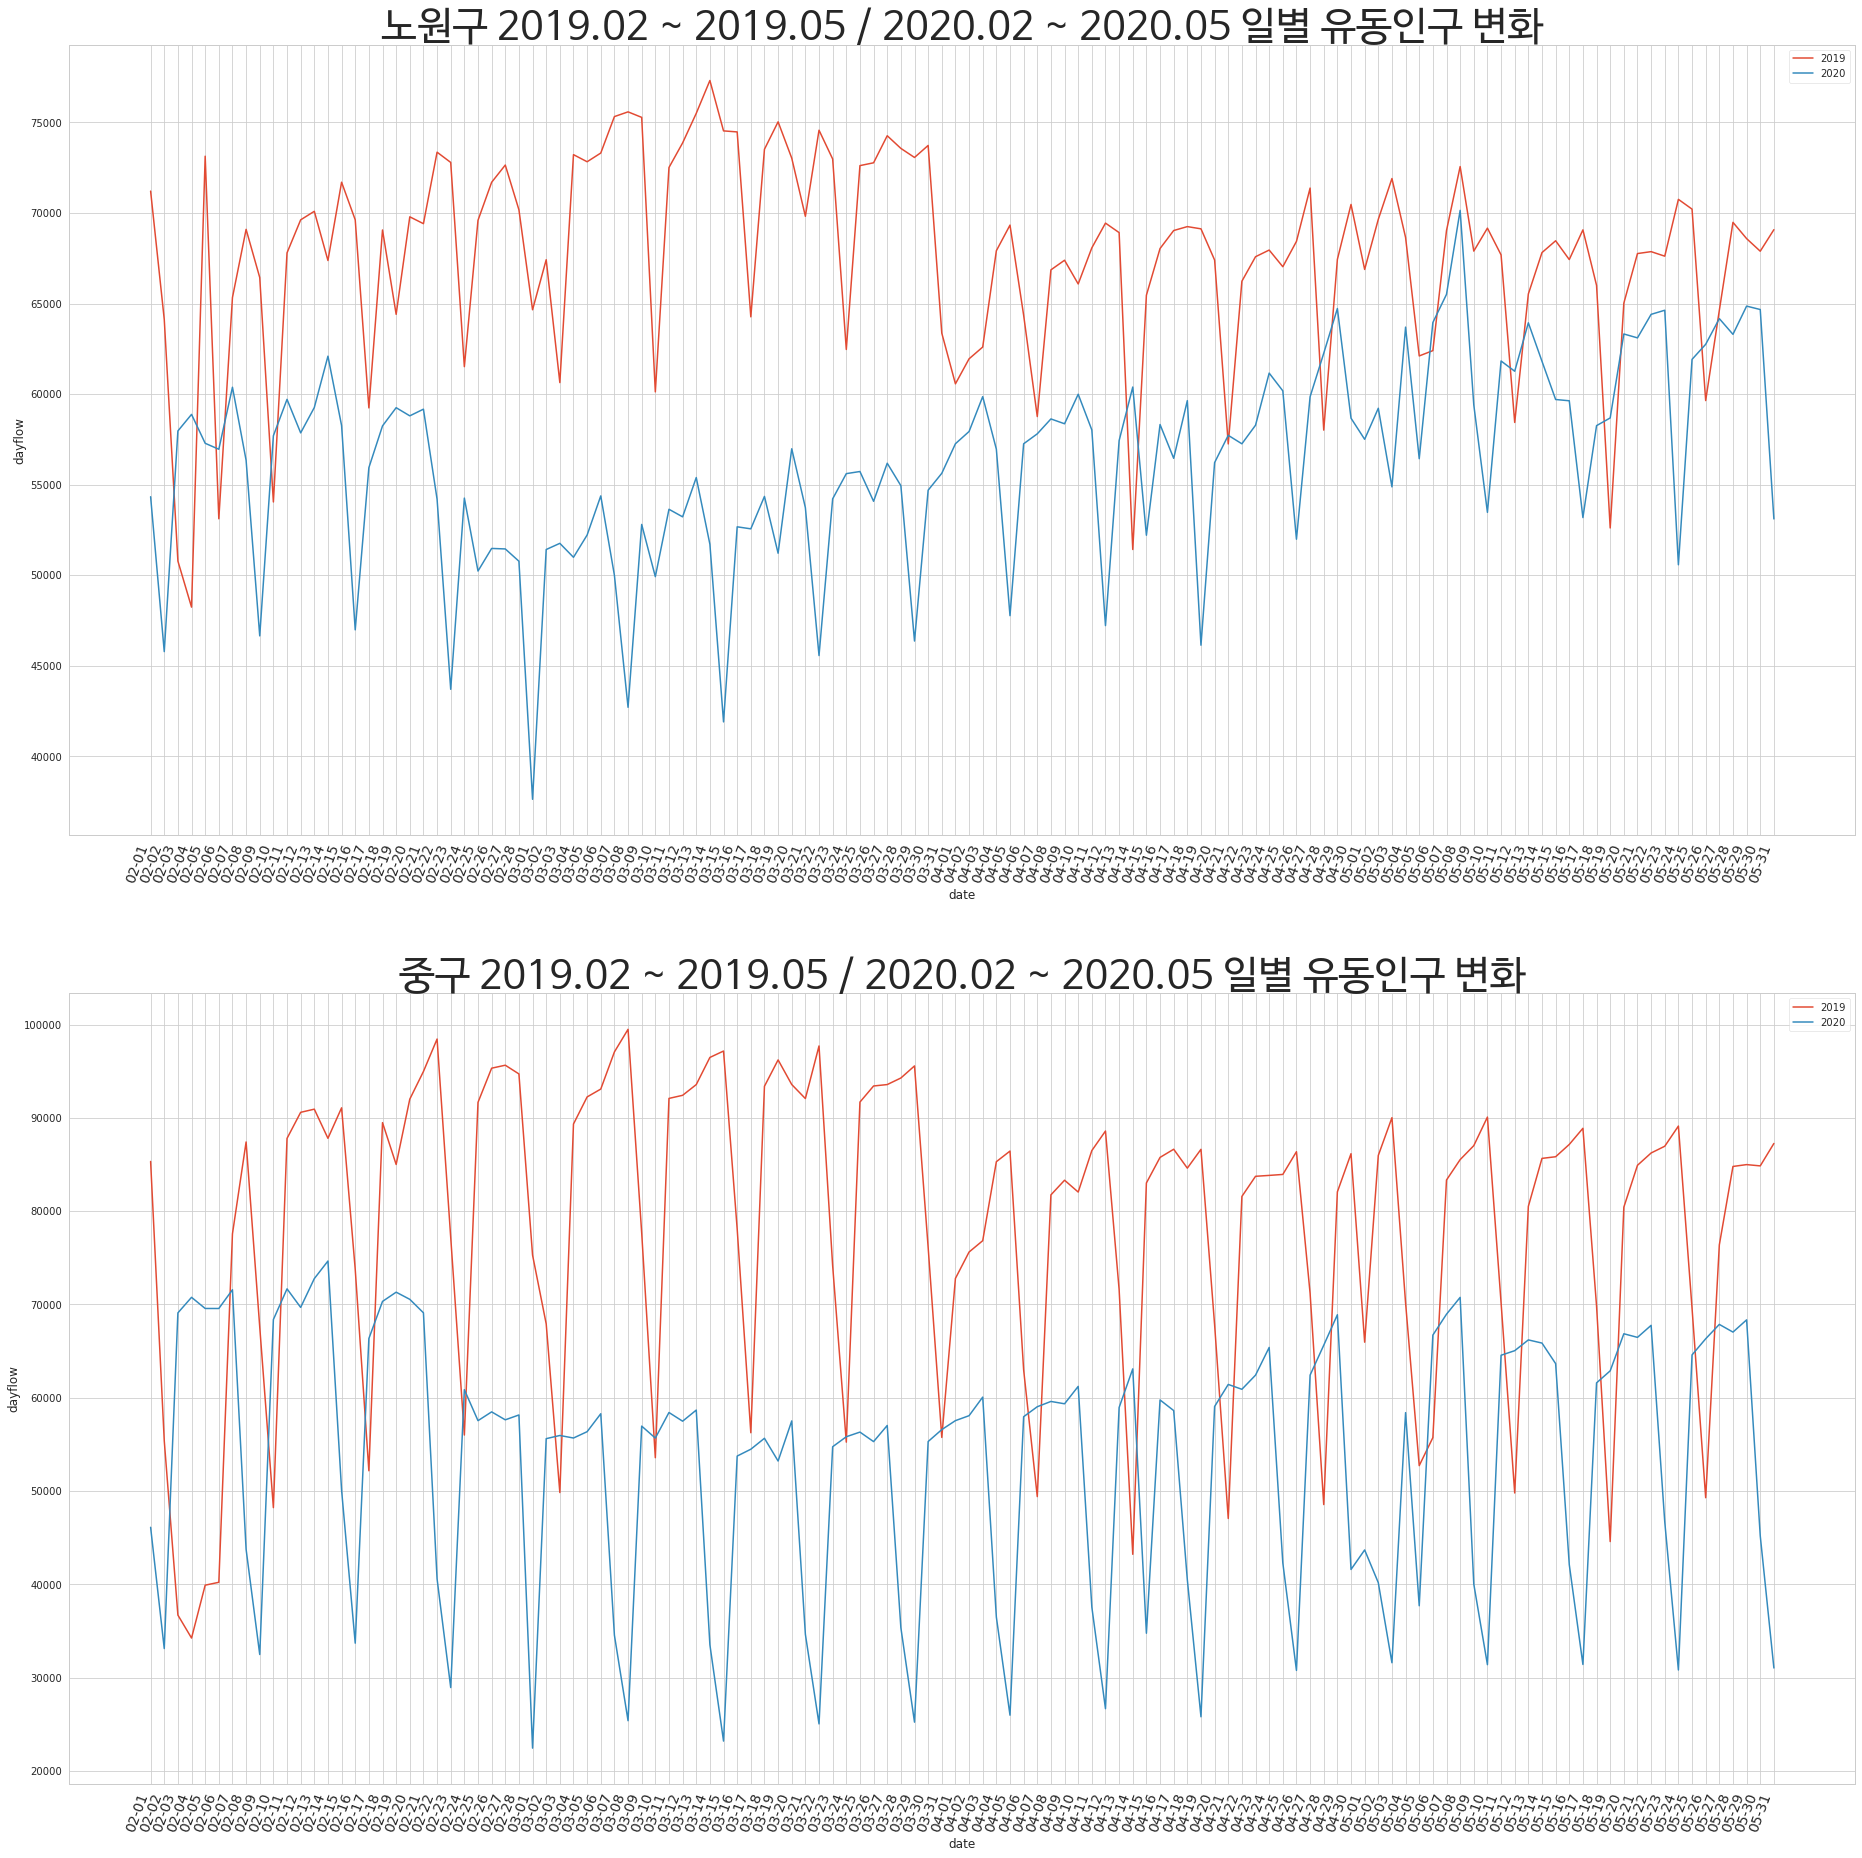

In [636]:
compare_dayflow(no_dayflow,sjung_dayflow,'노원구 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화',
               '중구 2019.02 ~ 2019.05 / 2020.02 ~ 2020.05 일별 유동인구 변화')

In [637]:
t_2019=time_df.set_index('date')['2019'].groupby('SI_NM').sum().loc[:,'TMST_00':'TMST_23'].T
t_2020=time_df.set_index('date')['2020'].groupby('SI_NM').sum().loc[:,'TMST_00':'TMST_23'].T

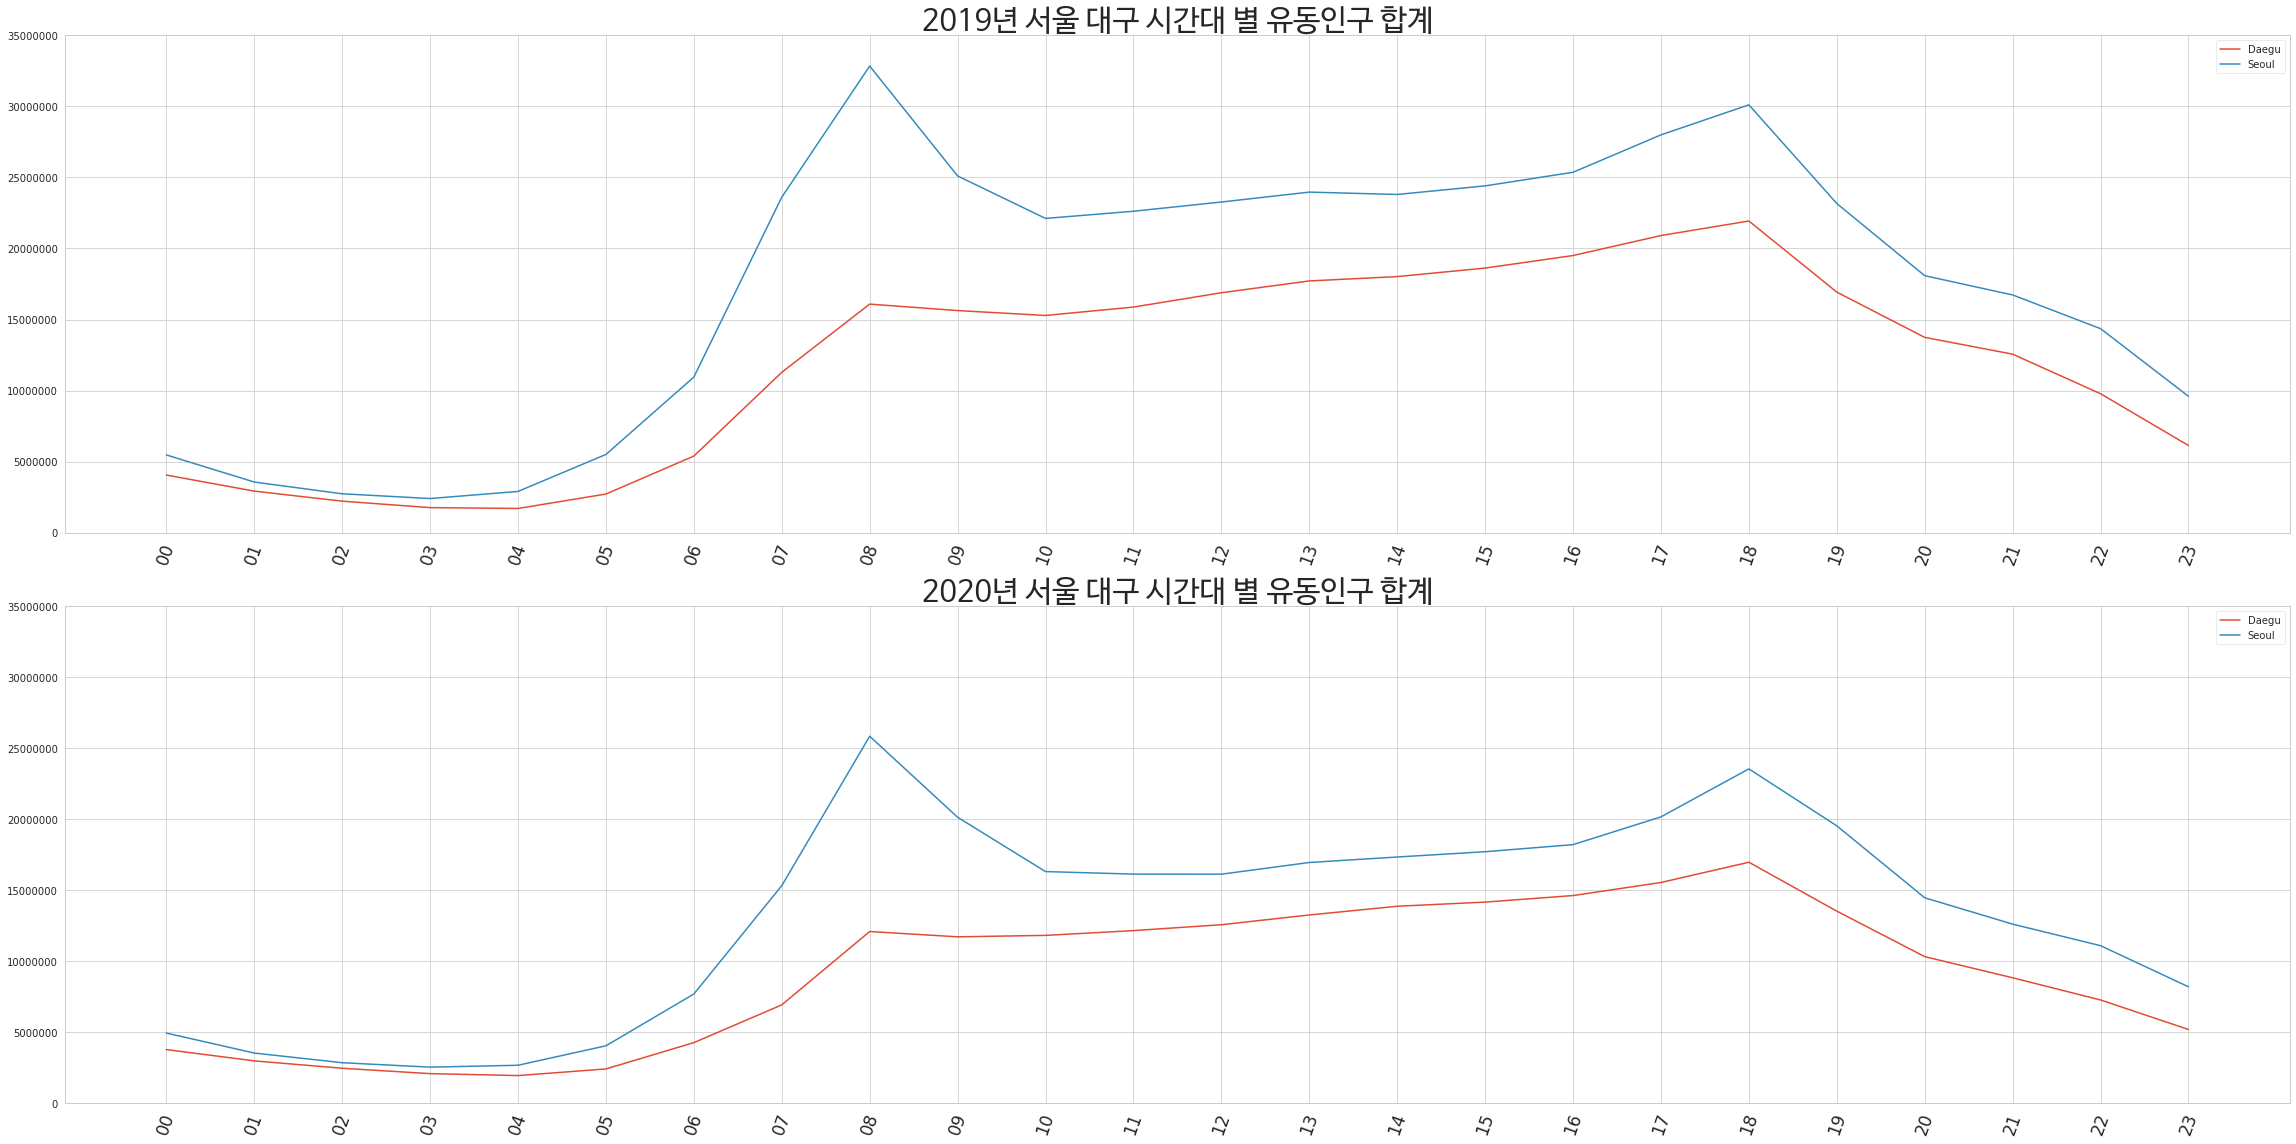

In [638]:
fig,axes=plt.subplots(2,1,figsize=(32,16))
y=2019
for dt,ax in zip([t_2019,t_2020],axes): 
    sns.lineplot(data=dt,dashes=False,ax=ax)
    ax.set_xticklabels(dt.index.str[5:],rotation=70,size=17)
    ax.ticklabel_format(style='plain',axis='y')
    ax.legend(['Daegu','Seoul'])
    ax.set_title(str(y)+'년 서울 대구 시간대 별 유동인구 합계',fontproperties=font,size=30)
    ax.set_ylim([0,35000000])
    y += 1
plt.tight_layout()
plt.show()

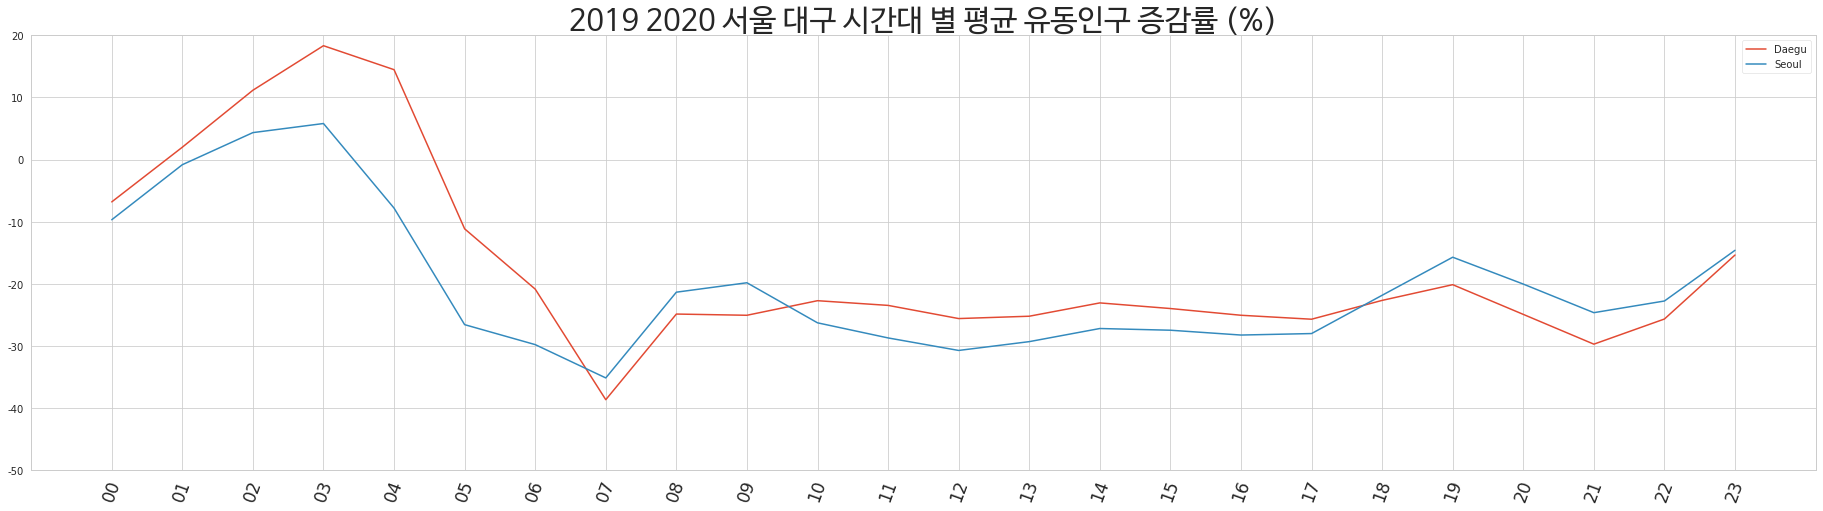

In [639]:
fig,ax=plt.subplots(figsize=(32,8))
dt=(t_2020-t_2019)/t_2019*100
sns.lineplot(data=dt,dashes=False,ax=ax)
ax.set_xticklabels(dt.index.str[5:],rotation=70,size=17)
ax.ticklabel_format(style='plain',axis='y')
ax.legend(['Daegu','Seoul'])
ax.set_title('2019 2020 서울 대구 시간대 별 평균 유동인구 증감률 (%)',fontproperties=font,size=30)
ax.set_ylim([-50,20])
plt.show()

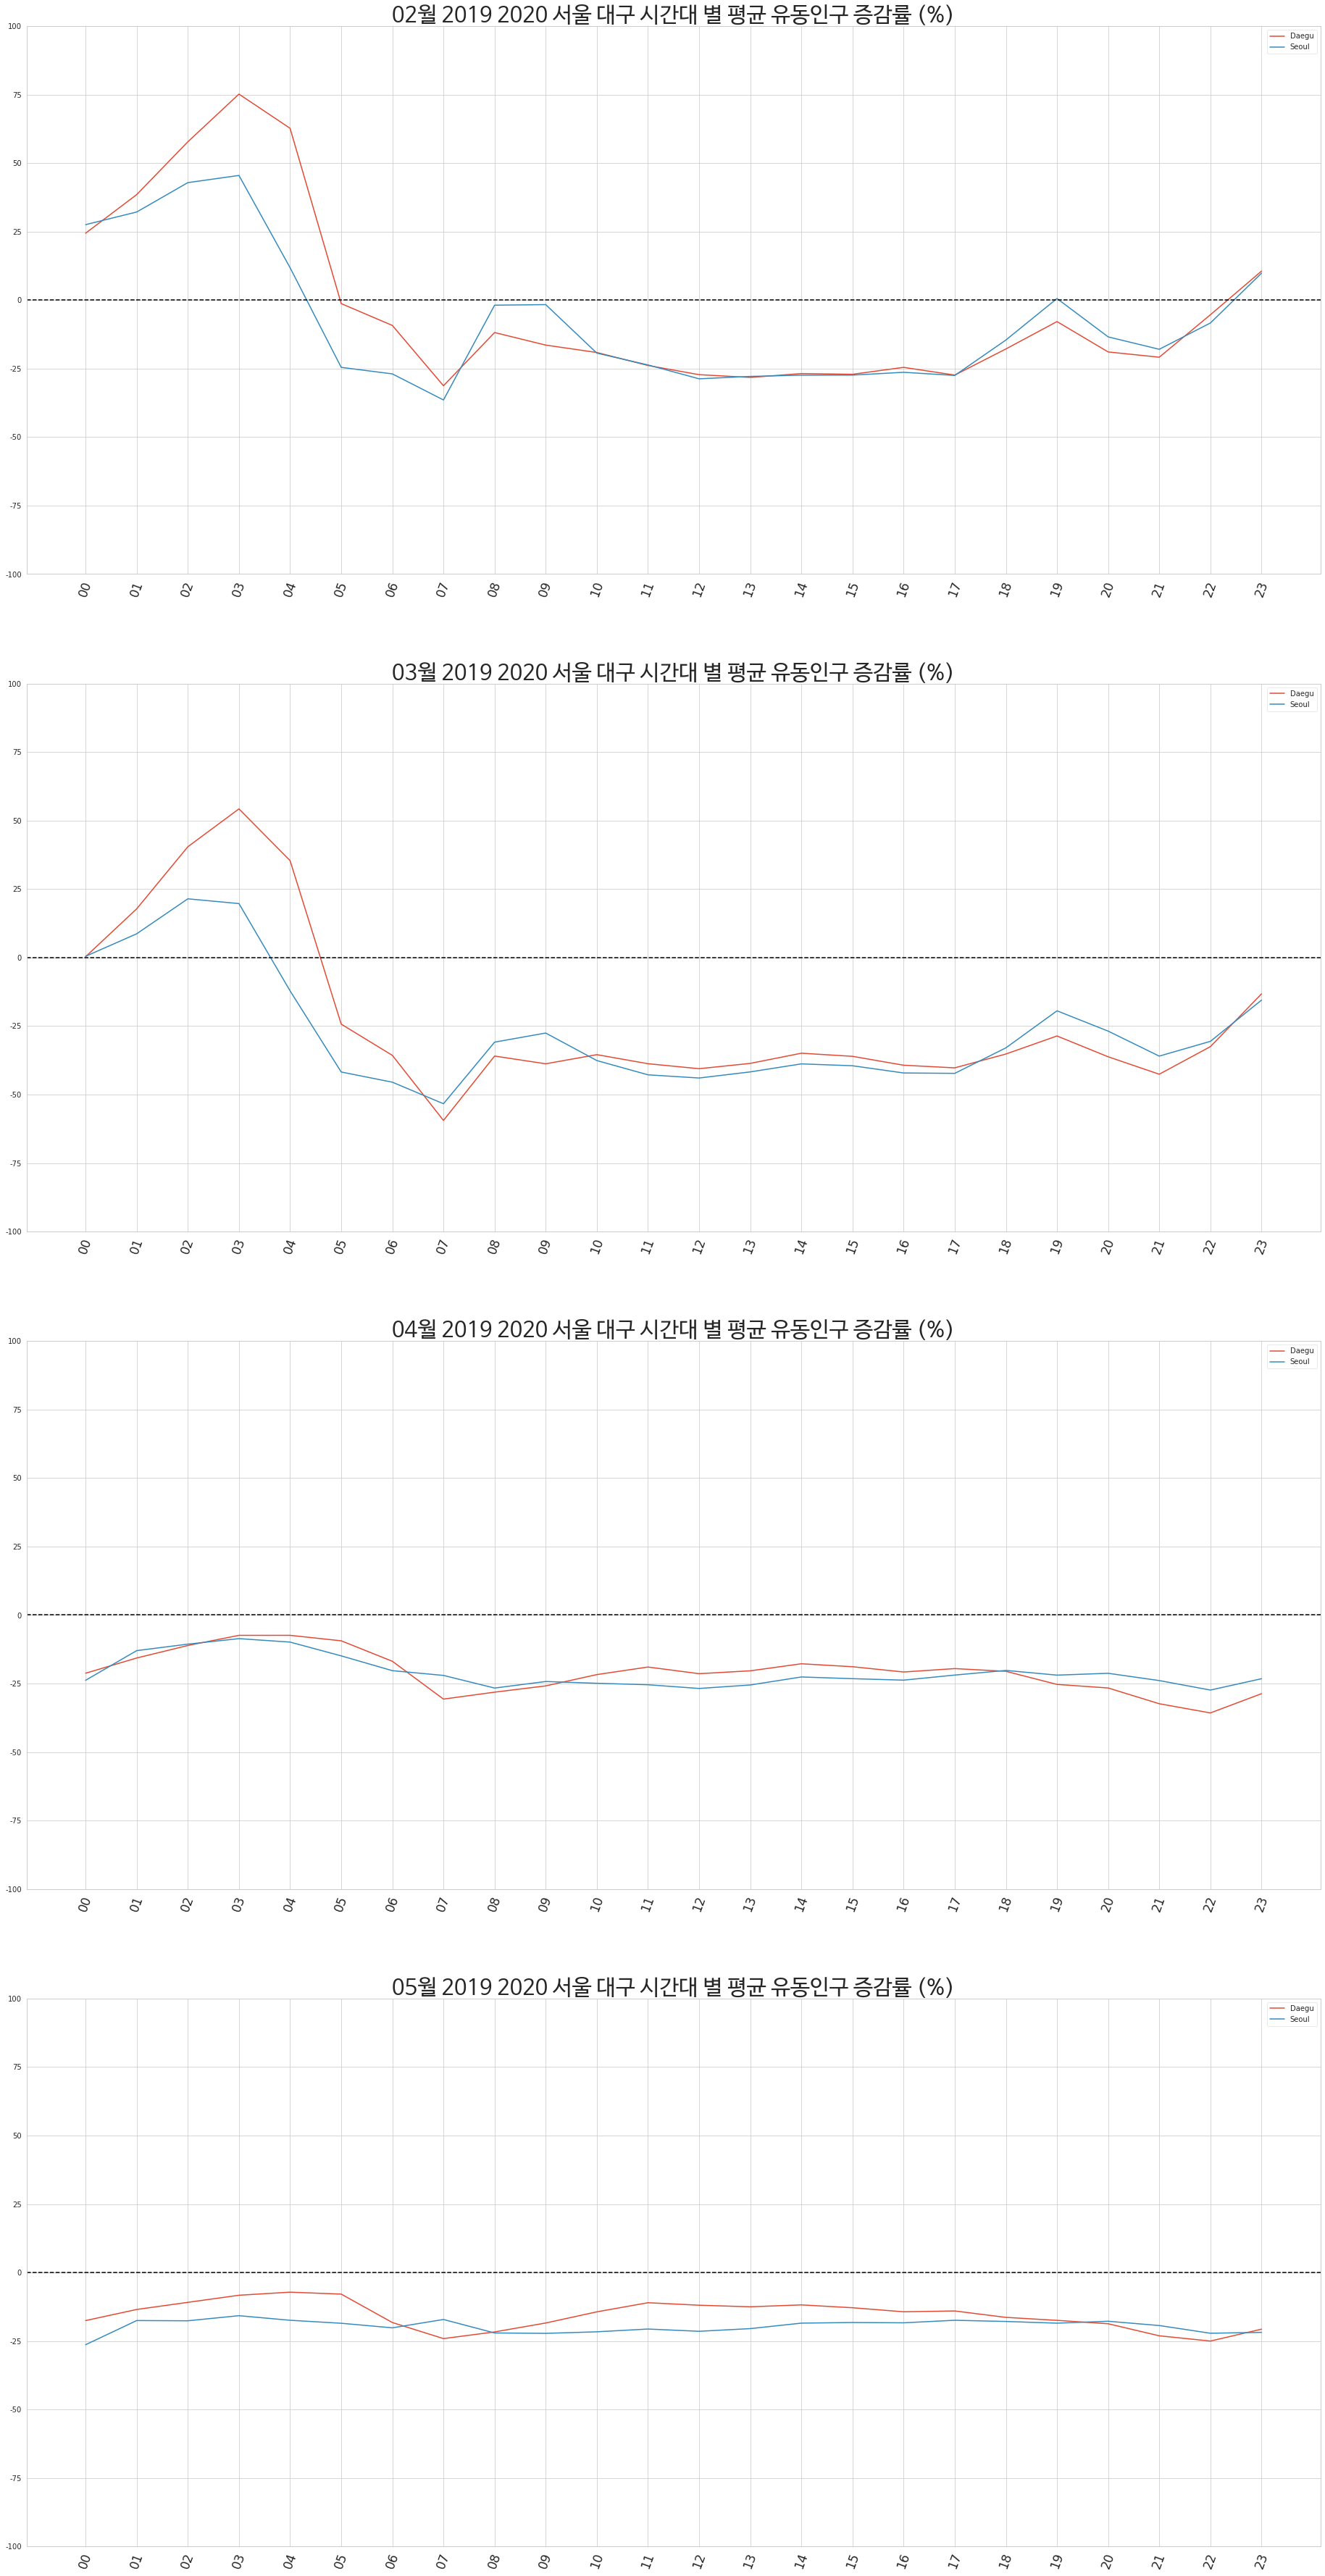

In [640]:
import itertools
fig,axes=plt.subplots(4,1,figsize=(32,64))
palette = sns.color_palette(palette=sns.crayon_palette(sns.colors.crayons))
new_palette = itertools.cycle(palette)
for i in ['02','03','04','05']:
    ax=axes[int(i[1])-2]
    t_2019=time_df.set_index('date')['2019-'+i].groupby('SI_NM').sum().loc[:,'TMST_00':'TMST_23'].T
    t_2020=time_df.set_index('date')['2020-'+i].groupby('SI_NM').sum().loc[:,'TMST_00':'TMST_23'].T
    y=2019
    dt=(t_2020-t_2019)/t_2019*100
    sns.lineplot(data=dt,dashes=False,ax=ax)
    ax.set_xticklabels(dt.index.str[5:],rotation=70,size=17)
    ax.ticklabel_format(style='plain',axis='y')
    ax.legend(['Daegu','Seoul'])
    ax.set_title(i+'월 2019 2020 서울 대구 시간대 별 평균 유동인구 증감률 (%)',fontproperties=font,size=30)
    ax.set_ylim([-100,100])
    ax.axhline(0, ls='--',c='k')
# plt.tight_layout()
plt.show()


In [641]:
temp_2019_02

,STD_YM,STD_YMD,HDONG_CD,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,...,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,dayflow
date,,,,,,,,,,,,,,,,,,,,,
1,7066570,706657035,95232125200,27466.35,19832.93,14059.73,10820.01,11606.76,22893.17,44519.88,...,195498.48,132444.24,214785.19,220071.87,165497.16,128481.63,118182.53,87117.52,52814.32,115276.42
2,7066570,706657070,95232125200,38994.24,28826.70,20780.05,16219.50,14859.81,22477.30,33564.76,...,198574.65,191960.09,197512.97,177942.85,138419.89,123740.85,109663.07,81823.77,54504.82,109761.49
3,7066570,706657105,95232125200,39519.14,29637.67,23041.45,16411.85,14548.90,19059.26,24064.13,...,167376.72,163584.16,161538.44,149097.47,121966.82,108236.85,97245.87,72314.92,49879.28,89722.32
4,7066570,706657140,95232125200,35685.60,26657.33,20355.25,15174.62,13934.67,17893.29,23692.98,...,143155.27,144260.78,145613.03,129870.60,116586.99,100699.24,84646.11,60139.09,39598.88,81995.77
5,7066570,706657175,95232125200,25677.11,17623.62,12557.43,9631.34,9306.07,16091.81,36590.07,...,177201.83,171718.68,166831.12,142320.05,123283.95,117638.08,103104.39,75124.63,49555.77,97960.63
6,7066570,706657210,95232125200,31828.01,22218.71,15925.94,12677.27,12352.98,17417.17,20476.23,...,175492.90,175304.65,168616.69,147980.36,125787.29,109444.14,90485.81,61556.76,37559.51,86065.44
7,7066570,706657245,95232125200,25327.89,17857.69,12901.84,10082.86,11122.17,23382.26,41304.05,...,171108.13,170097.86,182693.98,191683.50,127782.14,102499.15,94018.52,78501.75,38920.68,102974.19
8,7066570,706657280,95232125200,25137.45,17777.41,13241.11,10365.13,11016.69,22964.97,43115.83,...,176345.33,179747.60,197407.57,213444.74,150553.13,120590.50,110068.62,81093.54,51923.19,109256.52
9,7066570,706657315,95232125200,36151.24,25939.49,18904.66,14350.72,13149.70,22591.71,35785.87,...,174958.74,176283.21,185997.67,166920.84,127098.71,115443.82,98859.61,71594.39,47422.66,101907.84


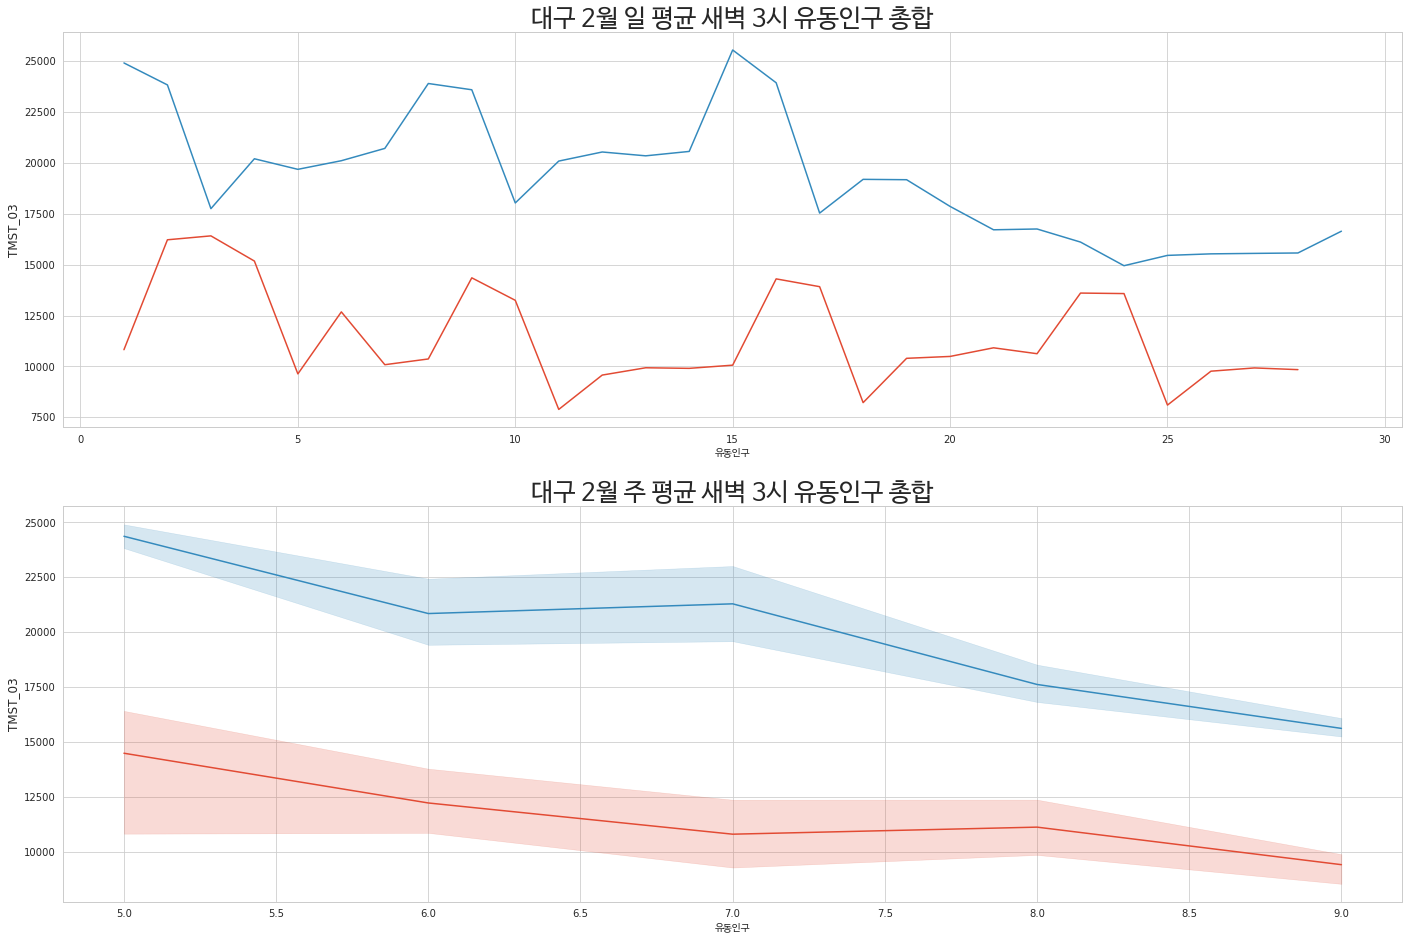

In [648]:
# 위 그래프 요일 요인 제거 필요 (28일만 집계)?
# 오전 3시에 유동인구 증가 / 2월 대구에서 75프로 증가 / 이유는?
fig,ax=plt.subplots(2,1,figsize=(24,16))
temp_2019_02=time_df[time_df['SI_NM']=='대구'].set_index('date')['2019-02'].groupby('date').sum()
temp_2020_02=time_df[time_df['SI_NM']=='대구'].set_index('date')['2020-02'].groupby('date').sum()
sns.lineplot(data=temp_2019_02,x=temp_2019_02.index.day,y='TMST_03',ax=ax[0])
sns.lineplot(data=temp_2020_02,x=temp_2020_02.index.day,y='TMST_03',ax=ax[0])
sns.lineplot(data=temp_2019_02,x=temp_2019_02.index.week,y='TMST_03',ax=ax[1])
sns.lineplot(data=temp_2020_02,x=temp_2020_02.index.week,y='TMST_03',ax=ax[1])
ax[0].set_xlabel('(일)',fontproperties=font)
ax[1].set_xlabel('(주차)',fontproperties=font)
ax[0].set_xlabel('유동인구',fontproperties=font)
ax[1].set_xlabel('유동인구',fontproperties=font)
ax[0].set_title('대구 2월 일 평균 새벽 3시 유동인구 총합',fontproperties=font,size=25)
ax[1].set_title('대구 2월 주 평균 새벽 3시 유동인구 총합',fontproperties=font,size=25)
plt.show()

In [649]:
# 2019 2020 2월 3월
# 가설
#1.꾸준히 새벽 유동인구가 증가
#2 새벽 유동인구의 폭등은 코로나로 인한것
#3 2020년 2월 3월에 코로나가 아닌 다른 요인

# x=동별 날짜에 따른 코로나 확진자 수 
# y=동별 시간대 유동인구 / 동별 나이대 유동인구 
# ==> 정상시계열로 변형,시계열 예측 모델 생성, 피쳐 중요도 및 R-square p-value 검정을 통해 확진자 수가 유의미한 피쳐가 되는 칼럼 도출 필요

# 주별 유동인구 추세

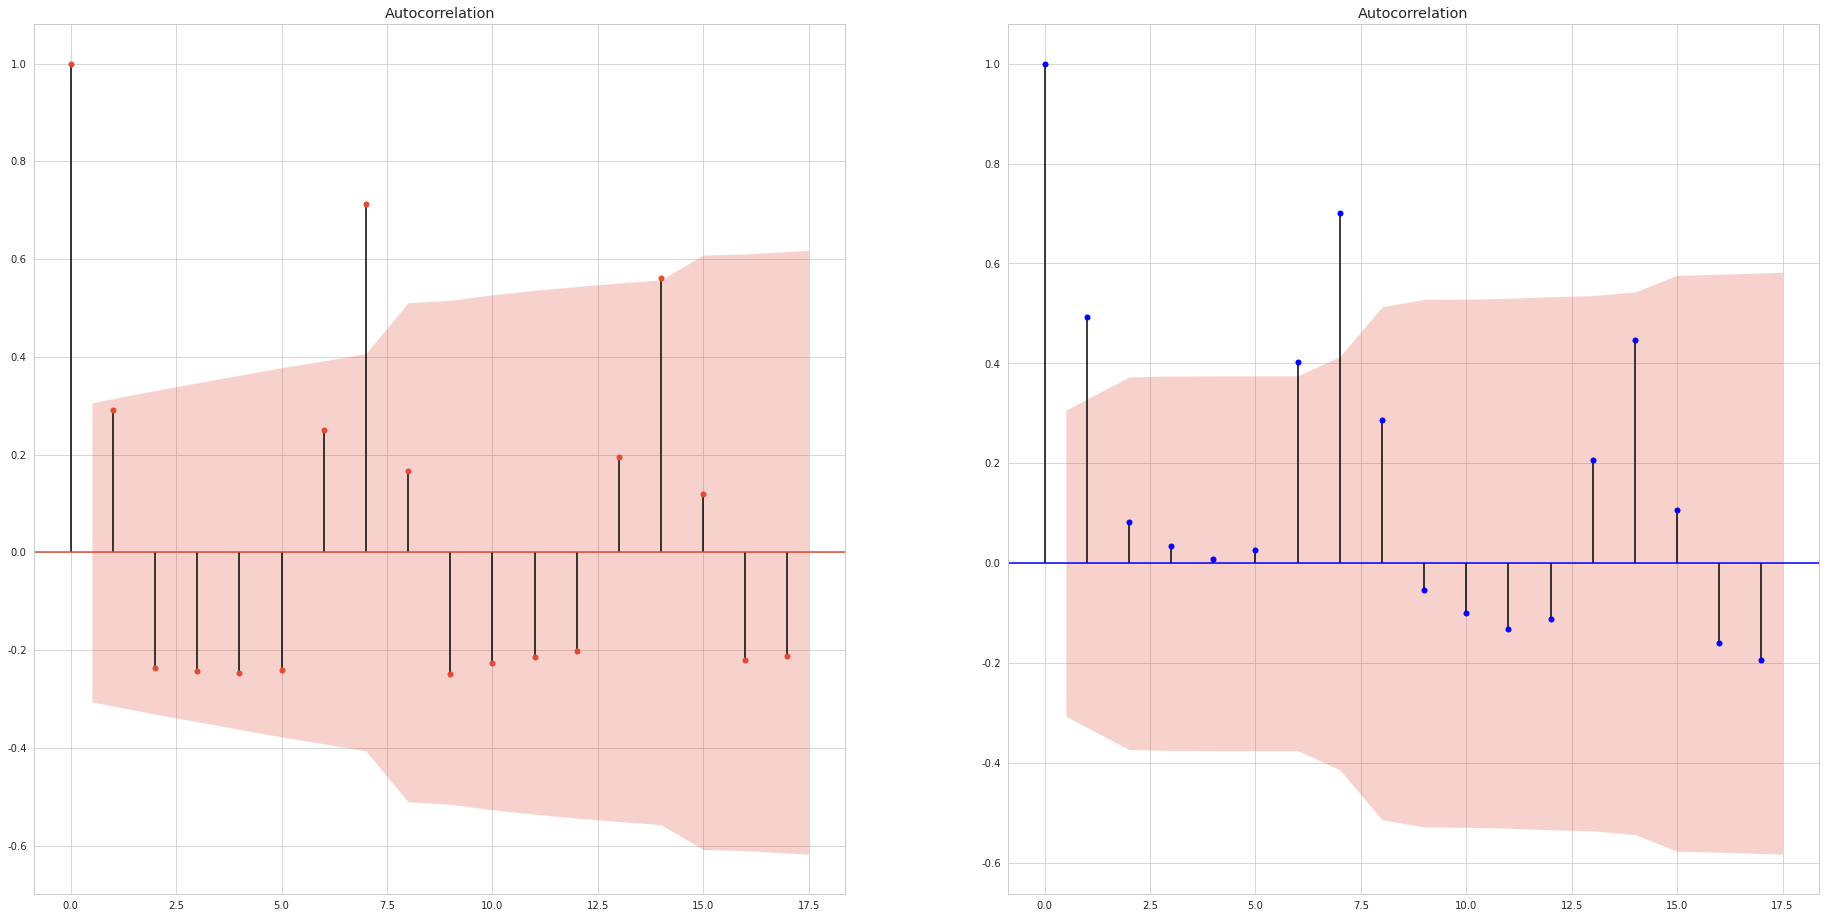

In [650]:
# 2019 2020 일간 유동인구 합 ACF

fig,ax=plt.subplots(1,2,figsize=(32,16))
plot_acf(acf(time_df.groupby('date').sum()['2019']['dayflow']),ax=ax[0],alpha=0.05)
plot_acf(acf(time_df.groupby('date').sum()['2020']['dayflow']),ax=ax[1],c='b',alpha=0.05)
plt.show()        

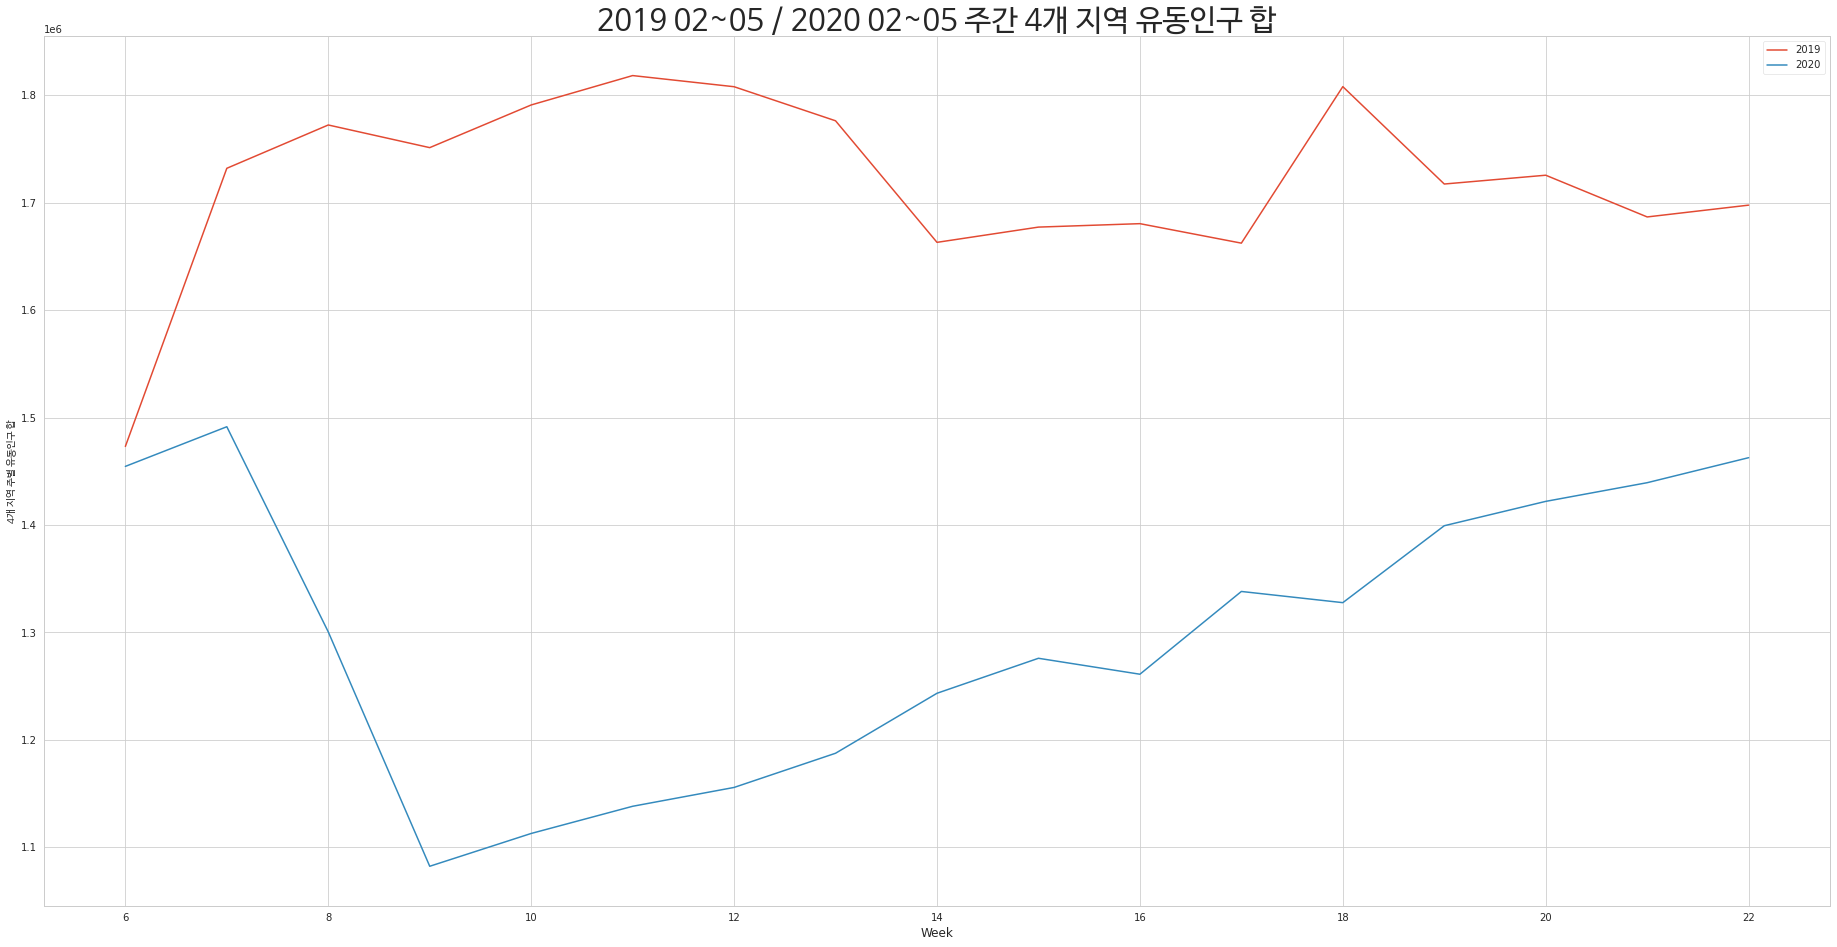

In [651]:
week_flow_2019=pd.DataFrame(time_df.groupby('date').sum()['2019'].resample('W-Fri')['dayflow'].sum()[1:]) # 토 ~ 금 집계 (제외 데이터 (2월 1일))
week_flow_2020=pd.DataFrame(time_df.groupby('date').sum()['2020'].resample('W-Sun')['dayflow'].sum()[1:]) # 월 ~ 일 집계 (제외 데이터 (2월 1일,2일))
week_flow_2019.index = week_flow_2019.index.week # 2019 6주 ~ 22주
week_flow_2020.index = week_flow_2020.index.week # 2020 6주 ~ 22주  

fig,ax=plt.subplots(figsize=(32,16))
sns.lineplot(data=week_flow_2019,x=week_flow_2019.index,y='dayflow',ax=ax,label='2019')
sns.lineplot(data=week_flow_2020,x=week_flow_2020.index,y='dayflow',ax=ax,label='2020')
ax.set_xlabel('Week')
ax.set_ylabel('4개 지역 주별 유동인구 합',fontproperties=font)
plt.title('2019 02~05 / 2020 02~05 주간 4개 지역 유동인구 합',fontproperties=font,size=30)
plt.legend()
plt.show()

# 일별 평균 유동인구와 확진자 수 상관관계

In [652]:
suseong_df=pd.read_csv('../input/suseonggu-corona/__.csv',sep=',',header=None)
suseong_df.columns=['date','누적 확진자 수']
suseong_df.head()

,date,누적 확진자 수
0,2.20,5
1,2.21,10
2,2.22,31
3,2.23,48
4,2.24,56


In [653]:
suseong_df=suseong_df.set_index('date')

In [654]:
suseong_df.index=suseong_df.index.astype(str)
suseong_ind = []
for i,ind in enumerate(suseong_df.index):
    ind=ind.replace('.','-')
    if len(ind) ==3:
        suseong_ind.append('2020-0'+ind+'0')
    else:
        suseong_ind.append('2020-0'+ind)
    
suseong_df.index= suseong_ind

In [655]:
suseong_df.index=pd.to_datetime(suseong_df.index,format='%Y-%m-%d')
suseong_df['누적 확진자 수']=suseong_df['누적 확진자 수'].str.replace(',','').astype(int)

In [656]:
suseong_df['당일 확진자 수']=suseong_df.diff()
suseong_df=suseong_df.fillna(5)
suseong_df['당일 확진자 수']=suseong_df['당일 확진자 수'].astype(int)

In [657]:
for i in pd.date_range("2/1/2020", "2/19/2020"):
        suseong_df.loc[i]=[0,0]
suseong_df=suseong_df.sort_index()

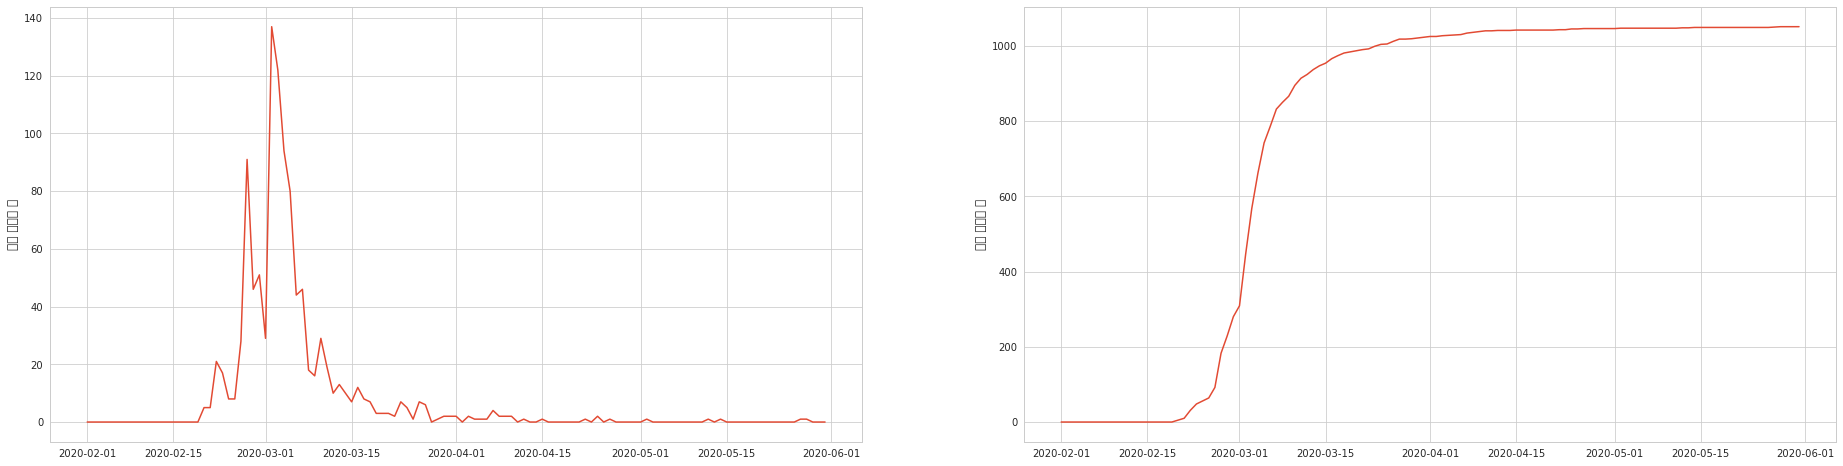

In [658]:
fig,ax = plt.subplots(1,2,figsize=(32,8))
sns.lineplot(data=suseong_df,x=suseong_df.index,y='당일 확진자 수',ax=ax[0])
sns.lineplot(data=suseong_df,x=suseong_df.index,y='누적 확진자 수',ax=ax[1])


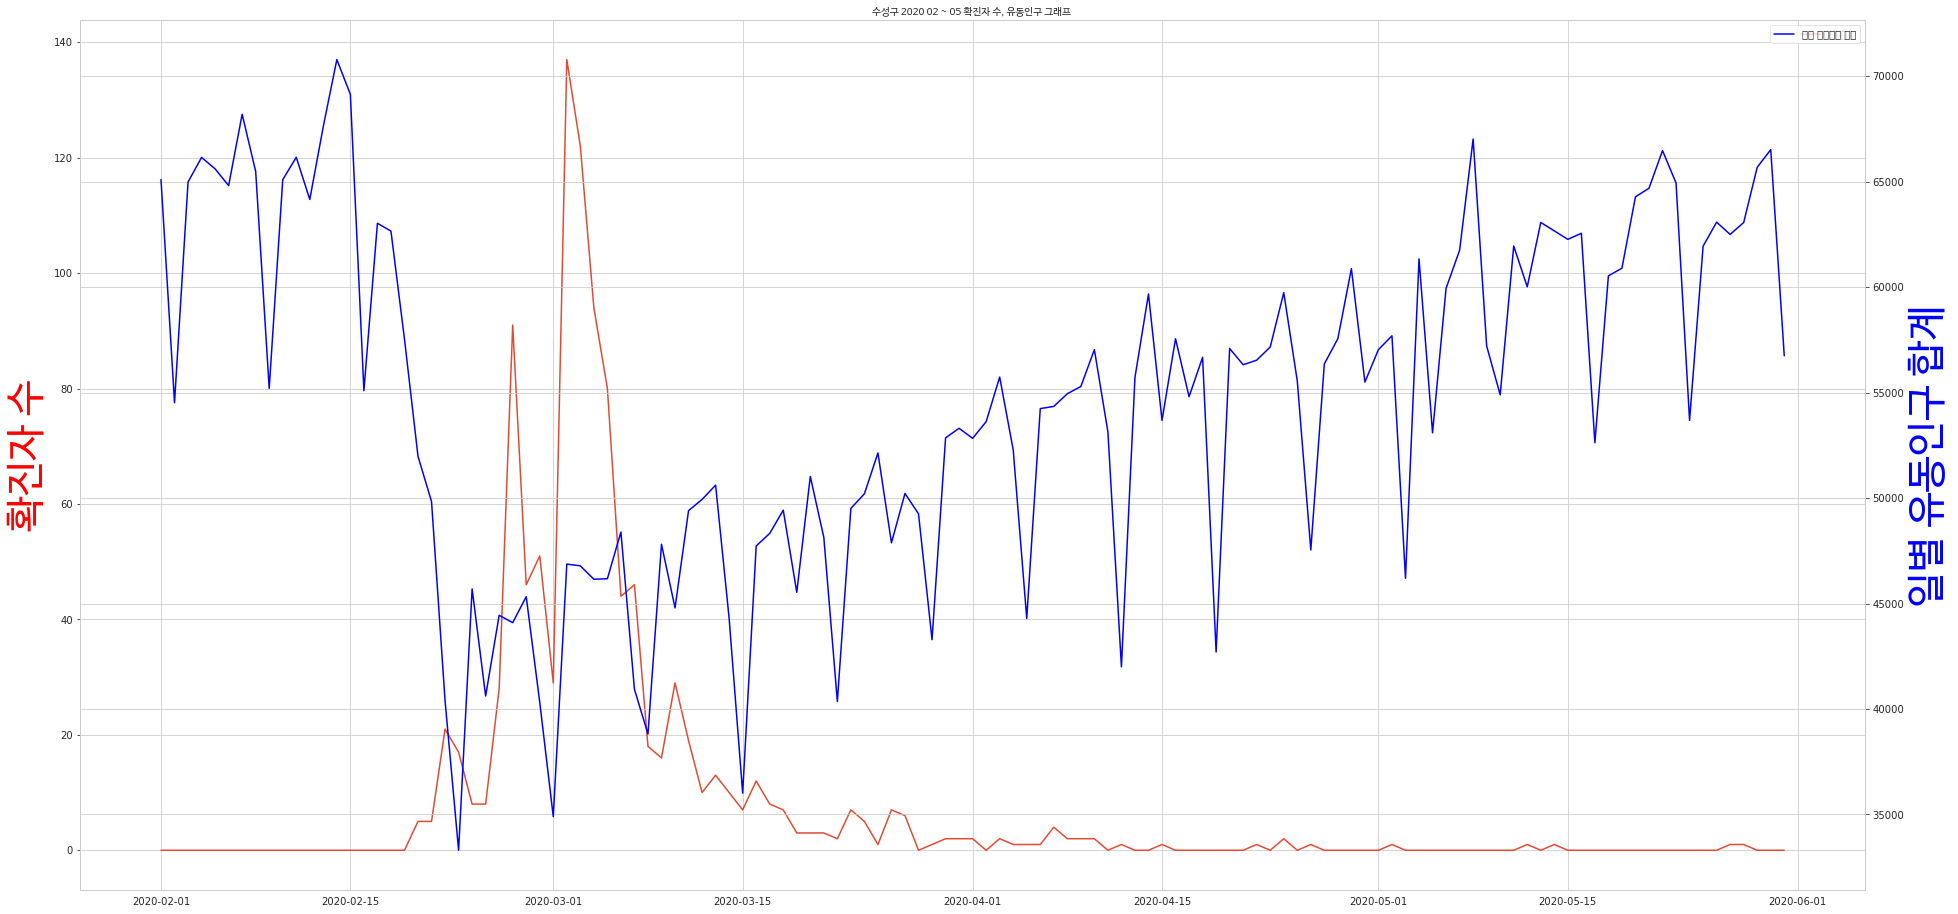

In [659]:
suseong_flow_df=suseong_dayflow.set_index('date')
fig,ax=plt.subplots(figsize=(32,16))
sns.lineplot(data=suseong_df,x=suseong_df.index,y='당일 확진자 수',ax=ax,label='확진자 수')
ax2 = ax.twinx()
sns.lineplot(data=suseong_flow_df['2020'],x=suseong_df.index,y='dayflow',ax=ax2,c='b',label='일별 유동인구 합계')
ax.set_ylabel('확진자 수',fontproperties=font,size=40,c='r')
ax2.set_ylabel('일별 유동인구 합계',fontproperties=font,size=40,c='b')
ax.set_title('수성구 2020 02 ~ 05 확진자 수, 유동인구 그래프 ',fontproperties=font)
plt.show()

In [660]:
suseong_time_flow=time_df[time_df['GU_NM']=='수성구'].groupby('date').sum()
suseong_time_flow.head()


,STD_YM,STD_YMD,HDONG_CD,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,...,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,dayflow
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,4643746,464374623,62699388000,21055.59,15366.48,10498.38,8279.48,8487.16,16123.48,30572.26,...,131843.21,91788.99,150033.03,156251.82,120414.19,94449.03,89752.09,65950.22,40279.51,79177.77
2019-02-02,4643746,464374646,62699388000,29796.22,21517.70,15246.60,11878.90,10374.11,15063.08,22251.29,...,133894.00,132132.02,138661.25,127582.81,101626.40,90099.77,82147.07,59981.04,41454.17,75516.51
2019-02-03,4643746,464374669,62699388000,30126.22,21708.27,16834.57,11696.53,10557.84,12942.50,15857.26,...,115782.56,114663.77,115277.02,108811.70,90023.46,79532.89,73772.52,54188.37,37873.19,62976.17
2019-02-04,4643746,464374692,62699388000,27111.26,19725.18,15144.56,11032.15,10066.50,12333.45,16164.59,...,100905.51,103163.74,105860.03,95408.15,87660.87,75864.88,65234.07,46111.26,30906.94,59186.49
2019-02-05,4643746,464374715,62699388000,19553.99,13149.08,9359.99,7148.75,6853.10,12141.84,28417.34,...,135413.25,132142.20,127800.90,106583.23,91433.90,89574.38,78004.62,57426.07,37727.54,74627.73


In [661]:
suseong_week_flow_2019=pd.DataFrame(suseong_time_flow['2019'].resample('W-Fri')['dayflow'].sum()[1:]) # 토 ~ 금 집계 (제외 데이터 (2월 1일))
suseong_week_flow_2020=pd.DataFrame(suseong_time_flow['2020'].resample('W-Sun')['dayflow'].sum()[1:]) # 월 ~ 일 집계 (제외 데이터 (2월 1일,2일))
suseong_week_flow_2019.index = suseong_week_flow_2019.index.week # 2019 6주 ~ 22주
suseong_week_flow_2020.index = suseong_week_flow_2020.index.week # 2020 6주 ~ 22주  

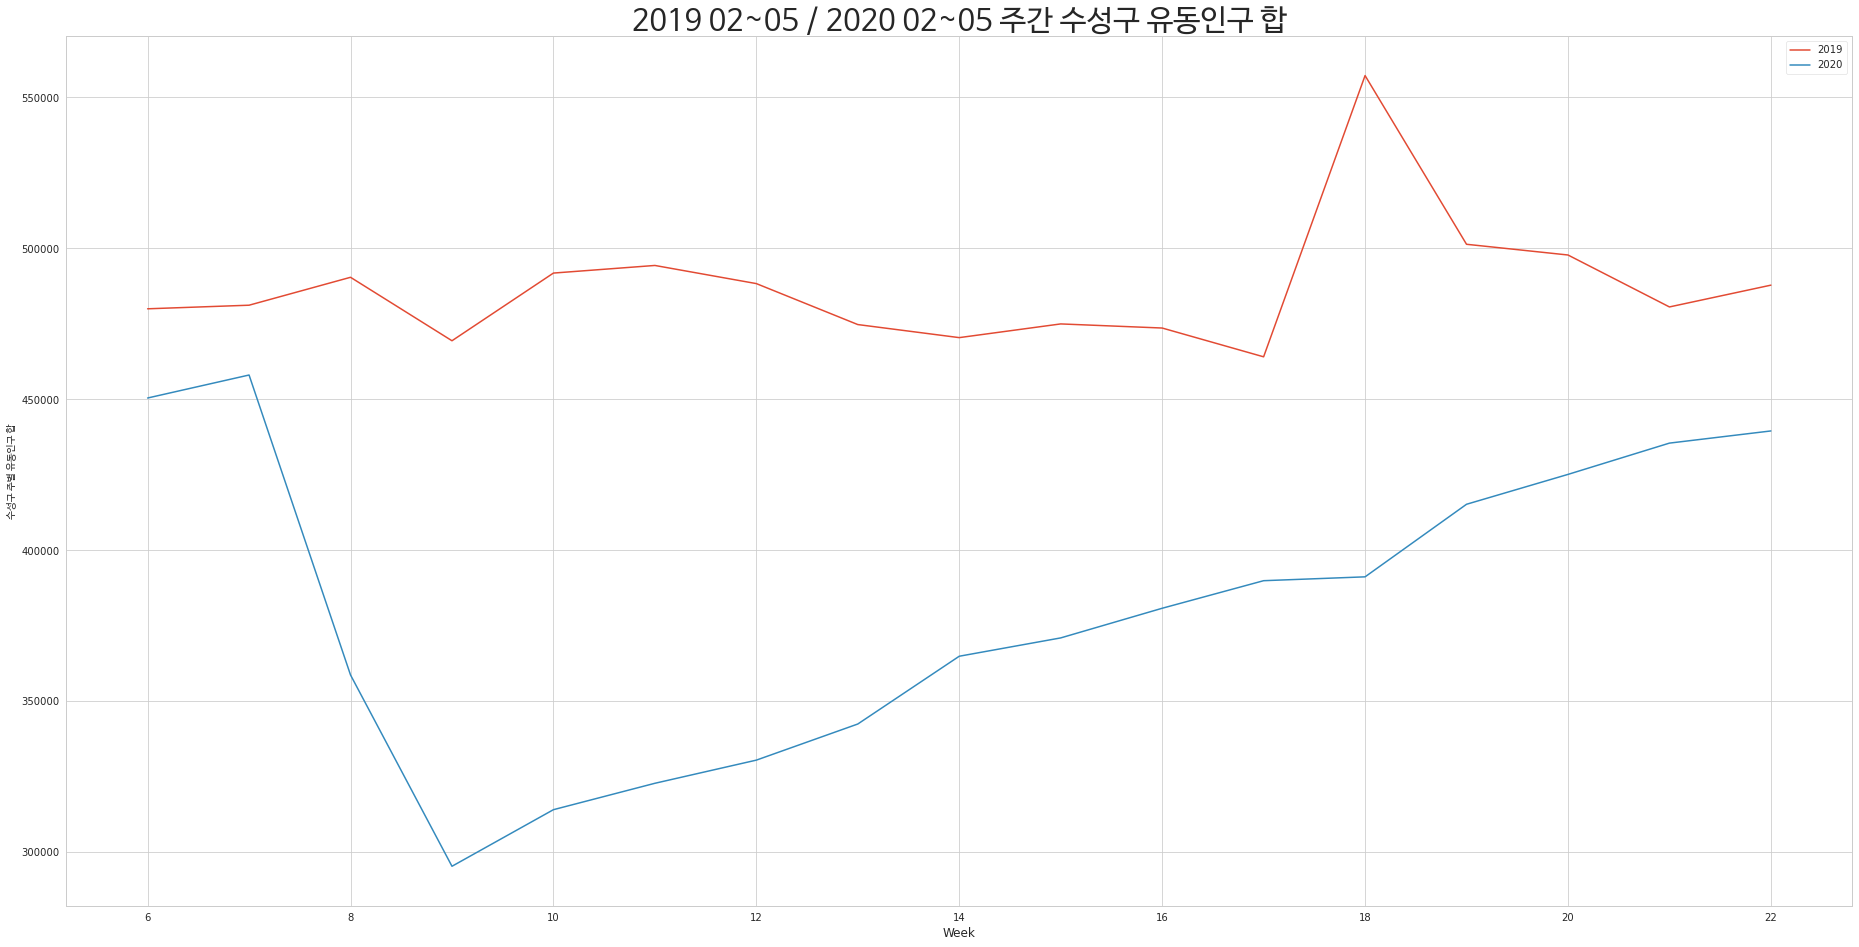

In [662]:
fig,ax=plt.subplots(figsize=(32,16))
sns.lineplot(data=suseong_week_flow_2019,x=suseong_week_flow_2019.index,y='dayflow',ax=ax,label='2019')
sns.lineplot(data=suseong_week_flow_2020,x=suseong_week_flow_2020.index,y='dayflow',ax=ax,label='2020')
ax.set_xlabel('Week')
ax.set_ylabel('수성구 주별 유동인구 합',fontproperties=font)
plt.title('2019 02~05 / 2020 02~05 주간 수성구 유동인구 합',fontproperties=font,size=30)
plt.legend()
plt.show()

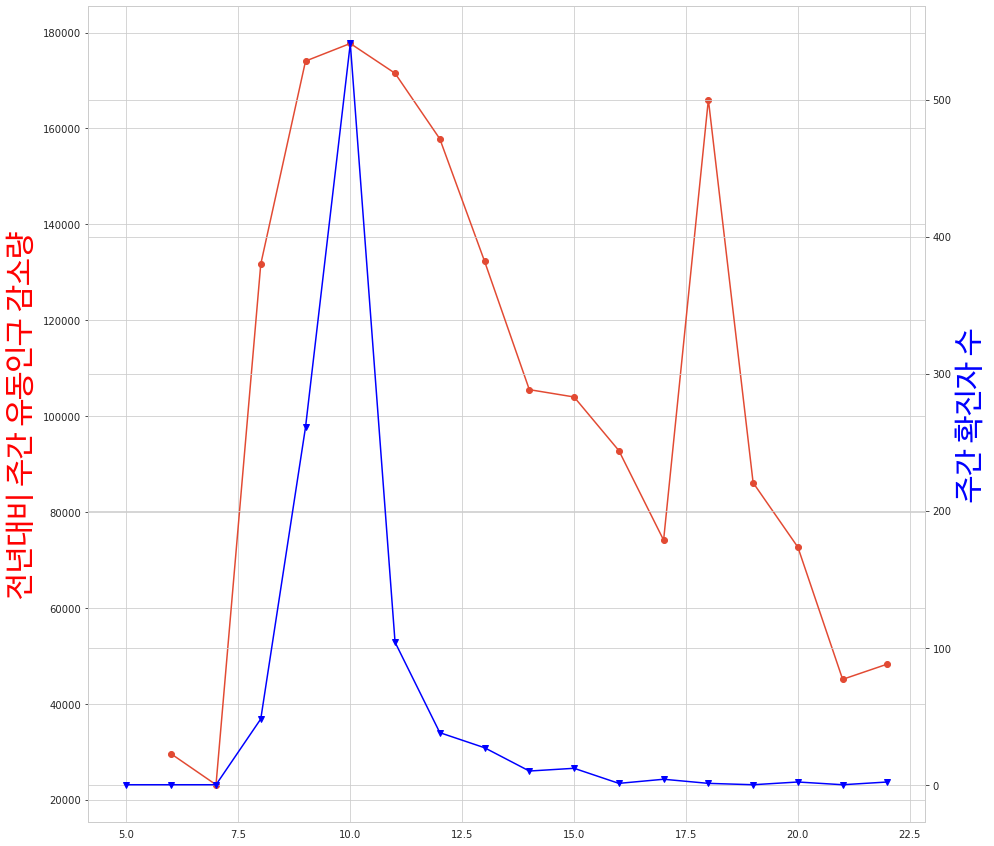

In [663]:
fig,ax=plt.subplots()
# sns.pointplot(data=suseong_week_flow_2019-suseong_week_flow_2020,x=suseong_week_flow_2019-suseong_week_flow_2020.index,y=(suseong_week_flow_2019-suseong_week_flow_2020).dayflow,
#               ax=ax,label='전년대비 주간 유동인구 감소량')
ax.plot(suseong_week_flow_2019-suseong_week_flow_2020,marker='o')
ax2=ax.twinx()
# sns.pointplot(data=suseong_df.resample('W-sun').sum(),x=suseong_df.resample('W-sun').sum().index.week,y='당일 확진자 수',ax=ax2,label='주간 확진자 수',c='b')
ax2.plot(suseong_df.resample('W-sun').sum().index.week,suseong_df.resample('W-sun').sum()['당일 확진자 수'],c='b',marker='v')
ax.set_ylabel('전년대비 주간 유동인구 감소량',fontproperties=font,size=30,c='r')
ax2.set_ylabel('주간 확진자 수',fontproperties=font,size=30,c='b')
plt.show()
#주차별 수성구 유동인구 감소량 (2019 - 2020)


In [664]:
print('2020 전년 대비 유동인구 급감 주 마지막 날짜', suseong_time_flow['2020'].resample('W-Fri').sum().index[(suseong_time_flow['2020'].resample('W-Fri').sum()).index.week.tolist().index(18)])
print('2019 전년 대비 유동인구 급감 주 마지막 날짜', suseong_time_flow['2019'].resample('W-Fri').sum().index[(suseong_time_flow['2019'].resample('W-Fri').sum()).index.week.tolist().index(18)])
# 18번째 주에서  급격한 유동인구 감소 (4월 27일 ~ 5월 3일 / 5월5일 어린이날, 5월 6일 대체휴일) 
# 20년 대구 컬러풀 페스티벌 취소

2020 전년 대비 유동인구 급감 주 마지막 날짜 2020-05-01 00:00:00
2019 전년 대비 유동인구 급감 주 마지막 날짜 2019-05-03 00:00:00


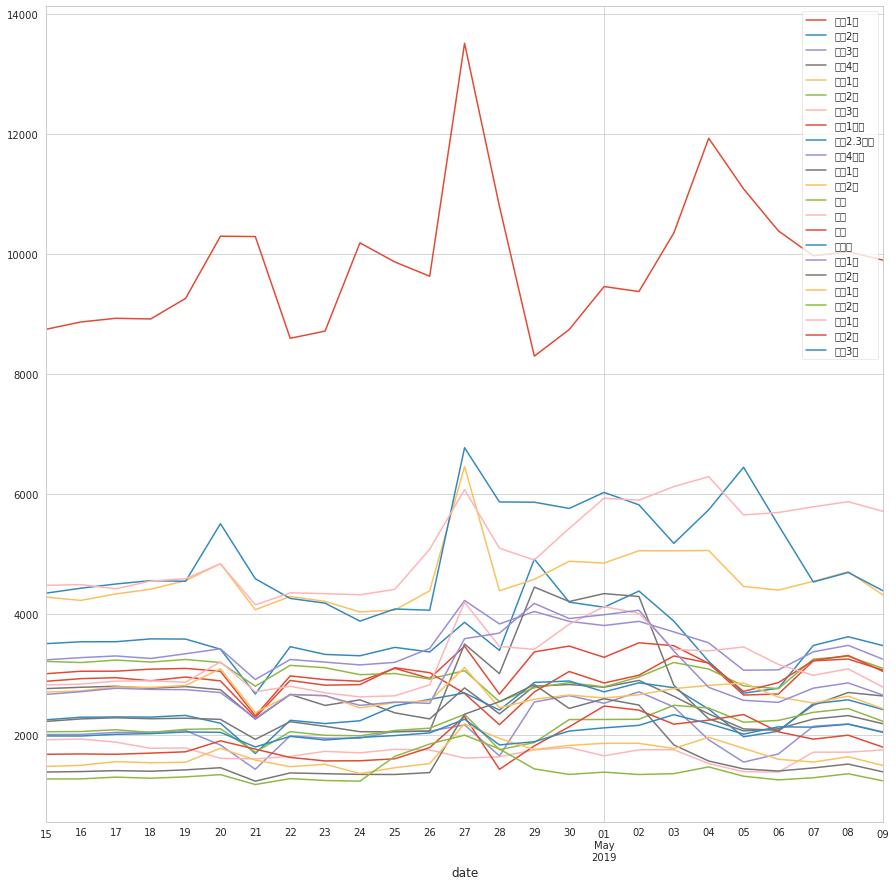

In [665]:
# time_df[time_df['GU_NM']=='수성구'].groupby(['HDONG_NM','date']).sum().loc['고산1동','dayflow']
suseong_dong_list=time_df[time_df['GU_NM']=='수성구'].HDONG_NM.unique().tolist()
for dong_nm in suseong_dong_list:
    gu_temp=time_df[time_df['GU_NM']=='수성구'].groupby(['HDONG_NM','date']).sum().loc[dong_nm,'dayflow']
    gu_temp[(gu_temp.index>='2019-04-15')&(gu_temp.index<='2019-05-09')].plot()
plt.legend(labels=suseong_dong_list)
plt.show()

In [ ]:
# time_df[time_df['GU_NM']=='수성구'].groupby(['HDONG_NM','date']).sum().loc['고산1동','dayflow']
suseong_dong_list=time_df[time_df['GU_NM']=='대구_중구'].HDONG_NM.unique().tolist()
for dong_nm in suseong_dong_list:
    gu_temp=time_df[time_df['GU_NM']=='대구_중구'].groupby(['HDONG_NM','date']).sum().loc[dong_nm,'dayflow']
    gu_temp[(gu_temp.index>='2019-04-15')&(gu_temp.index<='2019-05-09')].plot()
plt.legend(labels=suseong_dong_list)
plt.show()

In [ ]:
#대구 중구, 수성구 다수의 동에서 4월 27일 다른 주의 토요일보다 유동인구가 많았다 
"""지난 4월 27일(토), 불기2563년 부처님오신 날(4월 초팔일, 양력 5월 12일)을 맞아 대구 두류공원에
서는 약 천명의 외국인을 비롯하여 권영진대구시장, 
효광동화사주지스님과 불교계인사 및 시민 등등 5만여 명이 운집한 거운데 형형색색 달구벌 관등놀이가 성대하게 거행되었다.
연호동 위치 삼성라이온즈 파크 -> 4월 27일 홈 경기
5월 1일 근로자의 날 
"""

2. SNS

In [ ]:
home_training_df = pd.read_csv('../input/hometraining/hometrain.csv')
home_training_df

In [ ]:
home_training_df.rename(columns=home_training_df.iloc[0])
home_training_df = home_training_df.iloc[1:,:]

In [ ]:
home_training_df.head()

In [ ]:
home_training_df.reset_index(inplace=True)

In [ ]:
home_training_df.columns = ['date','ind']

In [ ]:
home_training_df['date']=pd.to_datetime(home_training_df['date'],format='%Y-%m-%d')

In [ ]:
home_training_df['ind']=home_training_df['ind'].apply(pd.to_numeric)

In [ ]:
fig,ax=plt.subplots()
sns.lineplot(x=home_training_df[home_training_df.date<='2019-09-15']['date'].apply(lambda x : x.strftime('%m-%d')),
            y=home_training_df[home_training_df.date<='2019-09-15']['ind'],ax=ax)
ax2 =ax.twinx()
ax.set_ylim([0, 100])
ax2.set_ylim([0, 100])
ax3=ax.twinx()
# ax3.set_ylim([-100,100])
sns.lineplot(x=home_training_df[(home_training_df.date>='2020-01-01')&(home_training_df.date<='2020-09-15')]['date'].apply(lambda x : x.strftime('%m-%d')),
            y=home_training_df[(home_training_df.date>='2020-01-01')&((home_training_df.date<='2020-09-15'))]['ind'],ax=ax2,c='b')
ax.xaxis.set_tick_params(rotation=45)
# sns.lineplot(x=home_training_df[(home_training_df.date>='2020-01-01')&(home_training_df.date<='2020-09-15')]['date'].apply(lambda x : x.strftime('%m-%d')),
#              y=home_training_df[(home_training_df.date>='2020-01-01')&((home_training_df.date<='2020-09-15'))]['ind'].values-home_training_df[home_training_df.date<'2019-09-15']['ind'].values,
#              ax=ax3,c='c')
                                                                                                                           
plt.title('구글 검색어 트렌드 : 홈트레이닝',fontproperties=font,size=30)
plt.show()